In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
//anaconda3/envs/timeseries36/bin/python


In [2]:
# import the base libraries
# standard libraries
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
import math
from itertools import cycle
import datetime

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import re
import csv
import json
import ast
from pandas.io.json import json_normalize

pd.options.display.max_colwidth = 2000
pd.set_option('display.max_rows', 100)


# for database connectivity
import psycopg2
import getpass

print(os.getcwd())

/Users/bryanbutler/Documents/Python/Forecasting/EWS


In [3]:
# user
# stream=sys.stderr
uid = getpass.getpass()

········


In [4]:
# pwd

pwd = getpass.getpass()

········


In [5]:
# connection

con=psycopg2.connect(dbname= 'dw_main', host='rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com', 
port= '5439', user= uid, password= pwd)
# del uid, pwd
cursor = con.cursor()

In [6]:
# set the cutoff date

cutoff_date = '2020-01-06'

In [7]:
# query
# this is for all key EWS data
# check the end date

sql_query = """
SELECT
       CAST(lcad.date_ride AS date) AS date_ride,
       CASE WHEN dt.holiday_flag LIKE 'Y' THEN 1 ELSE 0 END AS holiday,
       lcad.call_center_state,
       COUNT(DISTINCT lcad.ride_key) AS gross_rides,
       COUNT(distinct CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.ride_key ELSE NULL END) AS verified_paid_rides,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.cost_usd ELSE 0 END ) AS verified_paid_costs,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.miles ELSE 0 END ) AS verified_paid_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.ride_key ELSE NULL END) AS verified_paid_ambulatory_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_ambulatory_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.miles ELSE NULL END) AS verified_paid_ambulatory_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.ride_key ELSE NULL END) AS verified_paid_stretcher_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_stretcher_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.miles ELSE NULL END) AS verified_paid_stretcher_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.ride_key ELSE NULL END) AS verified_paid_wheelchair_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_wheelchair_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.miles ELSE NULL END) AS verified_paid_wheelchair_miles,
       
       count(distinct lcad.rider_code) AS Riders

FROM dw.fact_lcad_ride lcad

LEFT JOIN dw.dim_date dt
    ON lcad.date_dim_id = dt.date_dim_id
WHERE
      provider_type_name NOT IN ('Public Transit', 'Gas Reimbursement', 'Unassigned')
  AND provider_type_name IS NOT NULL
  AND date(date_ride) < %s 
  AND lcad.provider_is_lcad = 'LCAD'
  AND lcad.broker_client_contract_type != 'FFS'
  AND lcad.los_group_desc in ('Ambulatory' , 'Wheelchair', 'Stretcher')
GROUP BY date_ride, holiday, call_center_state
ORDER BY date_ride

""" 

In [8]:
data = pd.read_sql_query(sql = sql_query, con = con, params = [cutoff_date])
data.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1            14,106.09                 6738                             587   
2             1,778.93                  814                              98   
3               366.60                   92                               2   
4             1,040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
0                          365.25                        4,154.00   
1                        7,411.61                        8,524.00   
2                          390.07                          819.00   
3                          366.60                           92.00   
4                          999.58                        1,139.00   

   verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
0                              2                           0.00   
1                              5                         829.20   
2                             10                           0.00   
3                              0                            nan   
4                             27                           0.00   

   verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
0                           4.00                             300   
1                          49.00                             289   
2                          51.00                             195   
3                            nan                               0   
4                         165.00                              62   

   verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  riders  
0                          115.40                        2,162.00     387  
1                        5,865.28                        3,693.00     439  
2                        1,388.86                        1,400.00     153  
3                             nan                             nan       1  
4                           41.04                          290.00     128

In [9]:
# replace all NaN with 0
df = data.copy()

df = df.fillna(0)
df.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1            14,106.09                 6738                             587   
2             1,778.93                  814                              98   
3               366.60                   92                               2   
4             1,040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
0                          365.25                        4,154.00   
1                        7,411.61                        8,524.00   
2                          390.07                          819.00   
3                          366.60                           92.00   
4                          999.58                        1,139.00   

   verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
0                              2                           0.00   
1                              5                         829.20   
2                             10                           0.00   
3                              0                           0.00   
4                             27                           0.00   

   verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
0                           4.00                             300   
1                          49.00                             289   
2                          51.00                             195   
3                           0.00                               0   
4                         165.00                              62   

   verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  riders  
0                          115.40                        2,162.00     387  
1                        5,865.28                        3,693.00     439  
2                        1,388.86                        1,400.00     153  
3                            0.00                            0.00       1  
4                           41.04                          290.00     128

In [10]:
# convert date_ride to date and set as index
# only do this for direct SQL pull

# make a date
df['date_ride'] = pd.to_datetime(df['date_ride'], format='%Y-%m-%d')

# set the index
df = df.set_index(df['date_ride'])

df.head()

date_ride  holiday call_center_state  gross_rides  \
date_ride                                                       
2014-01-01 2014-01-01        1                HI          765   
2014-01-01 2014-01-01        1                MO          881   
2014-01-01 2014-01-01        1                AZ          303   
2014-01-01 2014-01-01        1                AR            2   
2014-01-01 2014-01-01        1                CA          242   

            verified_paid_rides  verified_paid_costs  verified_paid_miles  \
date_ride                                                                   
2014-01-01                    8               480.65                  162   
2014-01-01                  451            14,106.09                 6738   
2014-01-01                   64             1,778.93                  814   
2014-01-01                    2               366.60                   92   
2014-01-01                   30             1,040.62                  331   

            verified_paid_ambulatory_rides  verified_paid_ambulatory_costs  \
date_ride                                                                    
2014-01-01                             463                          365.25   
2014-01-01                             587                        7,411.61   
2014-01-01                              98                          390.07   
2014-01-01                               2                          366.60   
2014-01-01                             153                          999.58   

            verified_paid_ambulatory_miles  verified_paid_stretcher_rides  \
date_ride                                                                   
2014-01-01                        4,154.00                              2   
2014-01-01                        8,524.00                              5   
2014-01-01                          819.00                             10   
2014-01-01                           92.00                              0   
2014-01-01                        1,139.00                             27   

            verified_paid_stretcher_costs  verified_paid_stretcher_miles  \
date_ride                                                                  
2014-01-01                           0.00                           4.00   
2014-01-01                         829.20                          49.00   
2014-01-01                           0.00                          51.00   
2014-01-01                           0.00                           0.00   
2014-01-01                           0.00                         165.00   

            verified_paid_wheelchair_rides  verified_paid_wheelchair_costs  \
date_ride                                                                    
2014-01-01                             300                          115.40   
2014-01-01                             289                        5,865.28   
2014-01-01                             195                        1,388.86   
2014-01-01                               0                            0.00   
2014-01-01                              62                           41.04   

            verified_paid_wheelchair_miles  riders  
date_ride                                           
2014-01-01                        2,162.00     387  
2014-01-01                        3,693.00     439  
2014-01-01                        1,400.00     153  
2014-01-01                            0.00       1  
2014-01-01                          290.00     128

In [11]:
# convert data to weekly format

# weekly sample drops call center state
wdf = df.resample('W').aggregate({'holiday': np.max,
                                  'gross_rides': np.sum,
                                  'verified_paid_rides': np.sum,
                                  'verified_paid_costs': np.sum,
                                  'verified_paid_miles': np.sum,
                                  'verified_paid_ambulatory_rides': np.sum,
                                  'verified_paid_ambulatory_costs': np.sum,
                                  'verified_paid_ambulatory_miles': np.sum,
                                  'verified_paid_stretcher_rides': np.sum,
                                  'verified_paid_stretcher_costs': np.sum,
                                  'verified_paid_stretcher_miles': np.sum,
                                  'verified_paid_wheelchair_rides': np.sum,
                                  'verified_paid_wheelchair_costs': np.sum,
                                  'verified_paid_wheelchair_miles': np.sum,
                                  'riders': np.sum})
wdf.head()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2014-01-05        1       339193               151170         3,657,245.83   
2014-01-12        0       716978               417251        10,218,253.61   
2014-01-19        0       756659               464330        11,398,957.14   
2014-01-26        0       736904               388920         9,745,250.59   
2014-02-02        0       759988               414369        10,209,757.24   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2014-01-05              1858376                          276999   
2014-01-12              5160147                          594478   
2014-01-19              5772414                          629920   
2014-01-26              4933421                          613532   
2014-02-02              4948844                          633274   

            verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
date_ride                                                                    
2014-01-05                    2,521,979.56                    2,887,658.00   
2014-01-12                    7,425,178.64                    6,588,932.00   
2014-01-19                    8,320,541.03                    6,977,972.00   
2014-01-26                    7,050,347.37                    6,760,931.00   
2014-02-02                    7,460,196.84                    6,883,461.00   

            verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
date_ride                                                                  
2014-01-05                           7172                     267,237.82   
2014-01-12                          13331                     611,998.27   
2014-01-19                          13909                     679,684.35   
2014-01-26                          13468                     607,413.60   
2014-02-02                          13810                     604,284.39   

            verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
date_ride                                                                   
2014-01-05                      62,639.00                           55022   
2014-01-12                     129,201.00                          109169   
2014-01-19                     130,822.00                          112830   
2014-01-26                     125,796.00                          109904   
2014-02-02                     134,792.00                          112904   

            verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  \
date_ride                                                                    
2014-01-05                      868,028.45                      463,980.00   
2014-01-12                    2,181,076.70                      969,953.00   
2014-01-19                    2,398,731.76                    1,015,678.00   
2014-01-26                    2,087,489.62                      982,666.00   
2014-02-02                    2,145,276.01                    1,006,160.00   

            riders  
date_ride           
2014-01-05  167247  
2014-01-12  352948  
2014-01-19  371953  
2014-01-26  362595  
2014-02-02  373441

In [12]:
# import all of the stats functions to be used

import timeseries_module as ts

In [13]:
# get the oos data in weeks

oos = pd.read_csv('2019_2020_holidays.csv', index_col='date', parse_dates = True)
oos.head()

holiday
date               
2019-11-03        0
2019-11-10        0
2019-11-17        0
2019-11-24        0
2019-12-01        1

In [14]:
# clean up the verified_paid portion to vp

wdf.columns = wdf.columns.str.replace('verified_paid','vp')
wdf.head()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2014-01-05        1       339193    151170  3,657,245.83   1858376   
2014-01-12        0       716978    417251 10,218,253.61   5160147   
2014-01-19        0       756659    464330 11,398,957.14   5772414   
2014-01-26        0       736904    388920  9,745,250.59   4933421   
2014-02-02        0       759988    414369 10,209,757.24   4948844   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2014-01-05               276999         2,521,979.56         2,887,658.00   
2014-01-12               594478         7,425,178.64         6,588,932.00   
2014-01-19               629920         8,320,541.03         6,977,972.00   
2014-01-26               613532         7,050,347.37         6,760,931.00   
2014-02-02               633274         7,460,196.84         6,883,461.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2014-01-05                7172          267,237.82           62,639.00   
2014-01-12               13331          611,998.27          129,201.00   
2014-01-19               13909          679,684.35          130,822.00   
2014-01-26               13468          607,413.60          125,796.00   
2014-02-02               13810          604,284.39          134,792.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2014-01-05                55022           868,028.45           463,980.00   
2014-01-12               109169         2,181,076.70           969,953.00   
2014-01-19               112830         2,398,731.76         1,015,678.00   
2014-01-26               109904         2,087,489.62           982,666.00   
2014-02-02               112904         2,145,276.01         1,006,160.00   

            riders  
date_ride           
2014-01-05  167247  
2014-01-12  352948  
2014-01-19  371953  
2014-01-26  362595  
2014-02-02  373441

In [15]:
wdf.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-12-08        0       894311    597287 18,437,779.14   7316081   
2019-12-15        0       940555    631977 19,384,119.78   7751444   
2019-12-22        0       979626    647587 19,845,284.49   7886544   
2019-12-29        1       757684    379783 11,712,788.29   4341018   
2020-01-05        1       748943    389129 12,022,569.19   4747596   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-12-08               744867        12,904,658.26         9,181,793.00   
2019-12-15               786697        13,724,890.57         9,708,663.00   
2019-12-22               815841        13,970,148.04        10,015,541.00   
2019-12-29               609493         7,859,343.38         6,874,595.00   
2020-01-05               608516         8,302,625.03         7,198,940.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-12-08               15345        1,685,154.72          143,221.00   
2019-12-15               15909        1,737,038.44          154,132.00   
2019-12-22               17190        1,782,864.93          158,321.00   
2019-12-29               16269        1,242,512.94          125,732.00   
2020-01-05               15527        1,157,859.82          131,761.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-12-08               134099         3,847,966.16         1,236,383.00   
2019-12-15               137949         3,922,190.77         1,263,143.00   
2019-12-22               146595         4,092,271.52         1,329,721.00   
2019-12-29               131922         2,610,931.97         1,058,773.00   
2020-01-05               124900         2,562,084.34         1,049,901.00   

            riders  
date_ride           
2019-12-08  435241  
2019-12-15  456976  
2019-12-22  475574  
2019-12-29  369957  
2020-01-05  364918

In [16]:
# create cost per mile

wdf['cpm'] = wdf['vp_costs']/wdf['vp_miles']

In [265]:
print(cutoff_date)

2020-01-06


In [267]:
# reset the index for writing

wdf.reset_index(inplace=True)

date_ride  holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
0 2014-01-05        1       339193    151170  3,657,245.83   1858376   
1 2014-01-12        0       716978    417251 10,218,253.61   5160147   
2 2014-01-19        0       756659    464330 11,398,957.14   5772414   
3 2014-01-26        0       736904    388920  9,745,250.59   4933421   
4 2014-02-02        0       759988    414369 10,209,757.24   4948844   

   vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
0               276999         2,521,979.56         2,887,658.00   
1               594478         7,425,178.64         6,588,932.00   
2               629920         8,320,541.03         6,977,972.00   
3               613532         7,050,347.37         6,760,931.00   
4               633274         7,460,196.84         6,883,461.00   

   vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
0                7172          267,237.82           62,639.00   
1               13331          611,998.27          129,201.00   
2               13909          679,684.35          130,822.00   
3               13468          607,413.60          125,796.00   
4               13810          604,284.39          134,792.00   

   vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  riders  cpm  
0                55022           868,028.45           463,980.00  167247 1.97  
1               109169         2,181,076.70           969,953.00  352948 1.98  
2               112830         2,398,731.76         1,015,678.00  371953 1.97  
3               109904         2,087,489.62           982,666.00  362595 1.98  
4               112904         2,145,276.01         1,006,160.00  373441 2.06

In [268]:
# write wide and long to .csv

wdf.to_csv('wdf_cutoff_' + cutoff_date + '.csv', index = False)

In [17]:
# cut the data for verifiedd paid lag of ~ 66 days

vp_lag_days = 66

vp_lag_wks = int(vp_lag_days/7)+ (vp_lag_days % 7 > 0)


vpdf = wdf.iloc[:-vp_lag_wks]
vpdf.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-09-29        0       943292    656406 20,095,565.17   8058659   
2019-10-06        0       906442    621515 19,256,099.12   7659789   
2019-10-13        0       925897    638999 19,607,886.31   7837903   
2019-10-20        0       932062    638441 19,546,977.09   7798647   
2019-10-27        0       944285    655256 19,998,949.72   7992527   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-09-29               789281        14,135,937.04         9,796,333.00   
2019-10-06               755293        13,439,320.38         9,388,865.00   
2019-10-13               772670        13,742,240.80         9,591,852.00   
2019-10-20               778819        13,707,582.71         9,608,075.00   
2019-10-27               789892        14,065,021.51         9,746,398.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-09-29               15959        1,864,200.66          151,257.00   
2019-10-06               15769        1,848,272.82          154,847.00   
2019-10-13               16094        1,886,898.17          153,994.00   
2019-10-20               15854        1,834,207.50          149,091.00   
2019-10-27               15775        1,867,789.80          150,079.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-09-29               138052         4,095,427.47         1,287,620.00   
2019-10-06               135380         3,968,505.92         1,248,504.00   
2019-10-13               137133         3,978,747.34         1,254,662.00   
2019-10-20               137389         4,005,186.88         1,262,448.00   
2019-10-27               138618         4,066,138.41         1,278,256.00   

            riders  cpm  
date_ride                
2019-09-29  458096 2.49  
2019-10-06  440156 2.51  
2019-10-13  449387 2.50  
2019-10-20  452486 2.51  
2019-10-27  458569 2.50

# Get the Data in the Adjudication Gap
## Use as test data for rides and riders

In [18]:
test = wdf.iloc[-10:]
test

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-11-03        0       929504    636308 19,558,744.07   7772043   
2019-11-10        0       925150    638664 19,573,116.24   7814486   
2019-11-17        0       943713    631270 19,316,906.80   7655878   
2019-11-24        0       977459    670647 20,540,680.11   8204035   
2019-12-01        1       808955    451458 13,974,020.58   5341421   
2019-12-08        0       894311    597287 18,437,779.14   7316081   
2019-12-15        0       940555    631977 19,384,119.78   7751444   
2019-12-22        0       979626    647587 19,845,284.49   7886544   
2019-12-29        1       757684    379783 11,712,788.29   4341018   
2020-01-05        1       748943    389129 12,022,569.19   4747596   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-11-03               776900        13,773,240.42         9,617,259.00   
2019-11-10               772781        13,726,760.01         9,564,918.00   
2019-11-17               789220        13,505,619.60         9,686,301.00   
2019-11-24               816517        14,383,082.84        10,046,826.00   
2019-12-01               662156         9,425,178.18         7,767,490.00   
2019-12-08               744867        12,904,658.26         9,181,793.00   
2019-12-15               786697        13,724,890.57         9,708,663.00   
2019-12-22               815841        13,970,148.04        10,015,541.00   
2019-12-29               609493         7,859,343.38         6,874,595.00   
2020-01-05               608516         8,302,625.03         7,198,940.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-11-03               15499        1,818,279.72          146,295.00   
2019-11-10               15395        1,806,393.82          147,253.00   
2019-11-17               15833        1,809,939.29          149,213.00   
2019-11-24               16272        1,918,467.86          159,877.00   
2019-12-01               15055        1,514,998.77          135,678.00   
2019-12-08               15345        1,685,154.72          143,221.00   
2019-12-15               15909        1,737,038.44          154,132.00   
2019-12-22               17190        1,782,864.93          158,321.00   
2019-12-29               16269        1,242,512.94          125,732.00   
2020-01-05               15527        1,157,859.82          131,761.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-11-03               137105         3,967,223.93         1,246,078.00   
2019-11-10               136974         4,039,962.41         1,257,846.00   
2019-11-17               138660         4,001,347.91         1,267,668.00   
2019-11-24               144670         4,239,129.41         1,330,648.00   
2019-12-01               131744         3,033,843.63         1,128,358.00   
2019-12-08               134099         3,847,966.16         1,236,383.00   
2019-12-15               137949         3,922,190.77         1,263,143.00   
2019-12-22               146595         4,092,271.52         1,329,721.00   
2019-12-29               131922         2,610,931.97         1,058,773.00   
2020-01-05               124900         2,562,084.34         1,049,901.00   

            riders  cpm  
date_ride                
2019-11-03  452047 2.52  
2019-11-10  450049 2.50  
2019-11-17  458545 2.52  
2019-11-24  474579 2.50  
2019-12-01  392451 2.62  
2019-12-08  435241 2.52  
2019-12-15  456976 2.50  
2019-12-22  475574 2.52  
2019-12-29  369957 2.70  
2020-01-05  364918 2.53

# Set the Forecast Horizon
## Full horizon to include verified paid gap

In [19]:
horizon = 18

oos_exog = oos.iloc[:horizon]

oos_exog

holiday
date               
2019-11-03        0
2019-11-10        0
2019-11-17        0
2019-11-24        0
2019-12-01        1
2019-12-08        0
2019-12-15        0
2019-12-22        0
2019-12-29        1
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        1
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        1
2020-03-01        0

In [20]:
# set up for forecasting and backtesting
# set the ranges
train = vpdf.copy()

end = len(train)


# Gross Rides
## Uses VP Training Data

In [21]:
series = 'gross_rides'

In [22]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=13,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  304
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 13)   Log Likelihood               -3411.496
Date:                            Fri, 31 Jan 2020   AIC                           6836.993
Time:                                    12:22:46   BIC                           6862.682
Sample:                                01-05-2014   HQIC                          6847.285
                                     - 10-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.062e+05   2791.395    -38.054      0.000   -1.12e+05   -1.01e+05
ar.L1          0.0271      0.009      2.964      0.003       0.009       0.045
ar.L2         -0.9950      0.003   -314.309      0.000      -1.001      -0.989
ma.L1         -0.0747      0.013     -5.766      0.000      -0.100      -0.049
ma.L2          0.9904      0.033     29.667      0.000       0.925       1.056
ar.S.L13      -0.3285      0.012    -28.441      0.000      -0.351      -0.306
sigma2      8.741e+08      0.032   2.71e+10      0.000    8.74e+08    8.74e+08
===================================================================================
Ljung-Box (Q):                      120.97   Jarque-Bera (JB):               529.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+27. Standard errors may be unstable.
"""

In [23]:
ts.get_dw(model)

1.1840562364739986

In [24]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

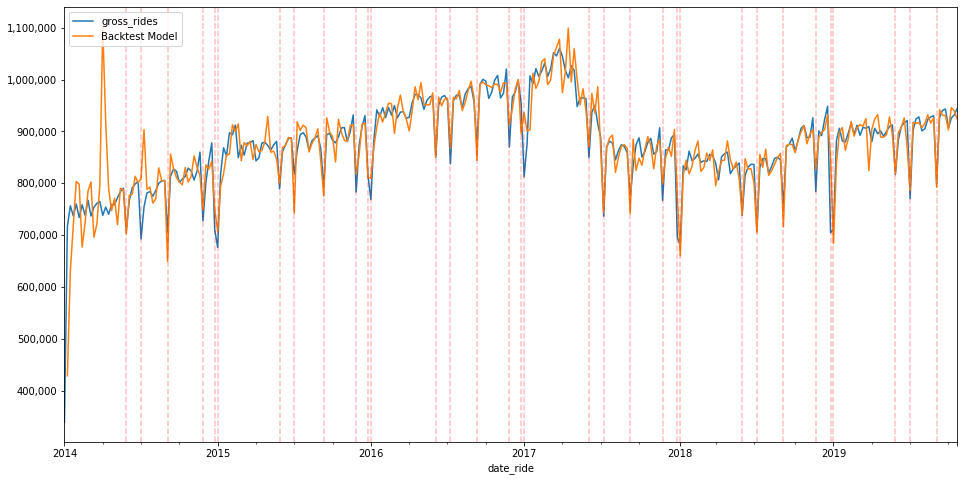

In [25]:
# make the backtest plot

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [26]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

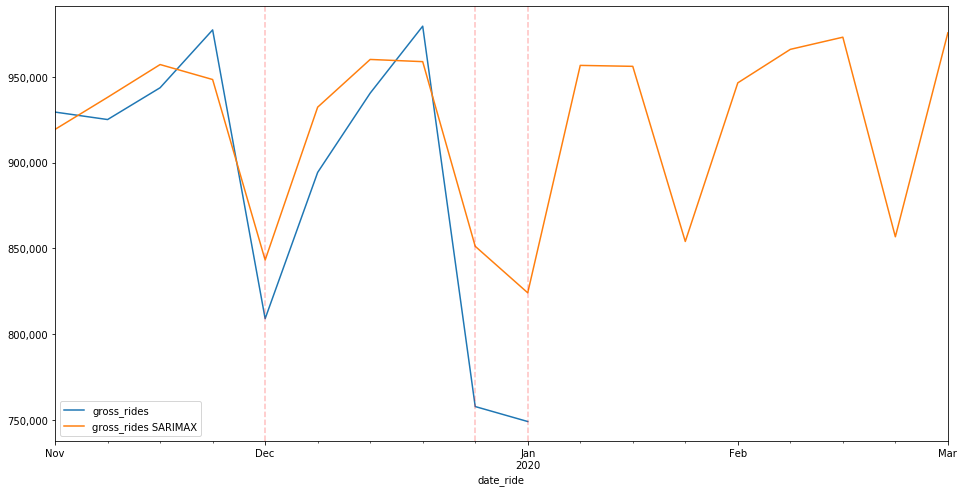

In [27]:
# plot predictions

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [28]:
# get the comparison of predictions to actual

compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

In [29]:
# error calculations from predictions and actual

ts.error_calcs(compare, predictions, test[series])

In [30]:
# make the confidence intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [31]:
intervals

In [32]:
# make the df for plotting OOS

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

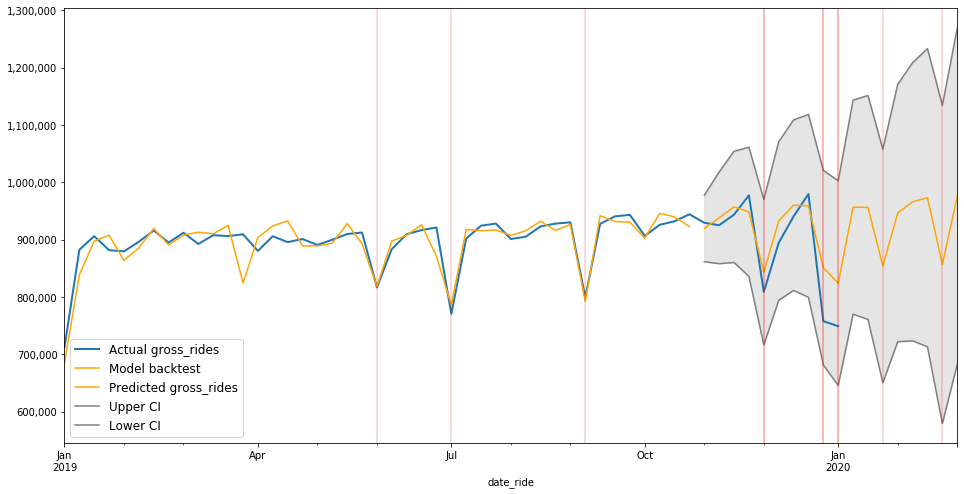

In [33]:
# oos plot

ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

# Riders

In [34]:
series = 'riders'

In [35]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  304
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -3209.245
Date:                            Fri, 31 Jan 2020   AIC                           6434.489
Time:                                    12:23:04   BIC                           6463.876
Sample:                                01-05-2014   HQIC                          6446.261
                                     - 10-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -5.52e+04   1937.896    -28.484      0.000    -5.9e+04   -5.14e+04
ar.L1          0.2636      0.009     30.293      0.000       0.247       0.281
ar.L2         -0.9980      0.009   -115.232      0.000      -1.015      -0.981
ma.L1         -0.2726      0.016    -16.636      0.000      -0.305      -0.241
ma.L2          0.9972      0.044     22.468      0.000       0.910       1.084
ar.S.L12       0.1722      0.040      4.278      0.000       0.093       0.251
ma.S.L12      -0.8633      0.039    -22.212      0.000      -0.939      -0.787
sigma2      2.291e+08      0.017   1.31e+10      0.000    2.29e+08    2.29e+08
===================================================================================
Ljung-Box (Q):                      100.33   Jarque-Bera (JB):               443.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.21e+25. Standard errors may be unstable.
"""

In [36]:
ts.get_dw(model)

1.2349943257739193

In [37]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

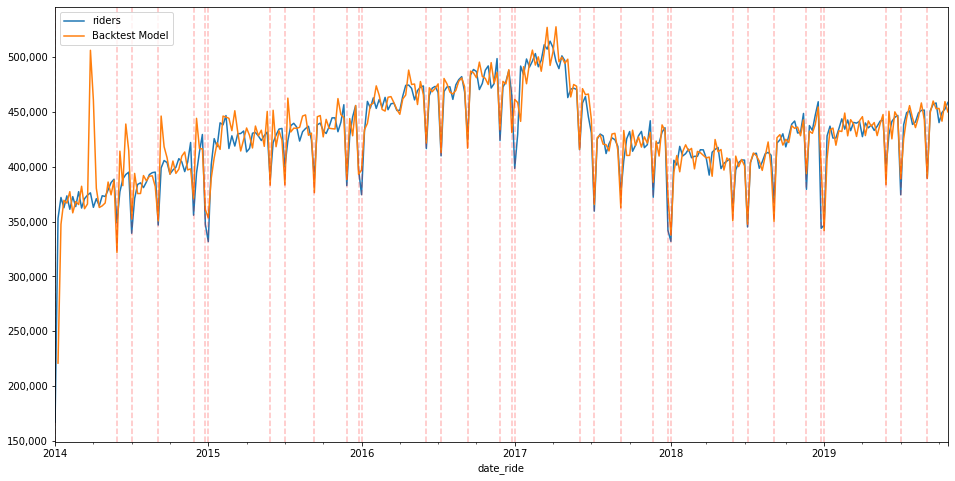

In [38]:
ts.plot_fit(train[series], backtest, train)

In [39]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

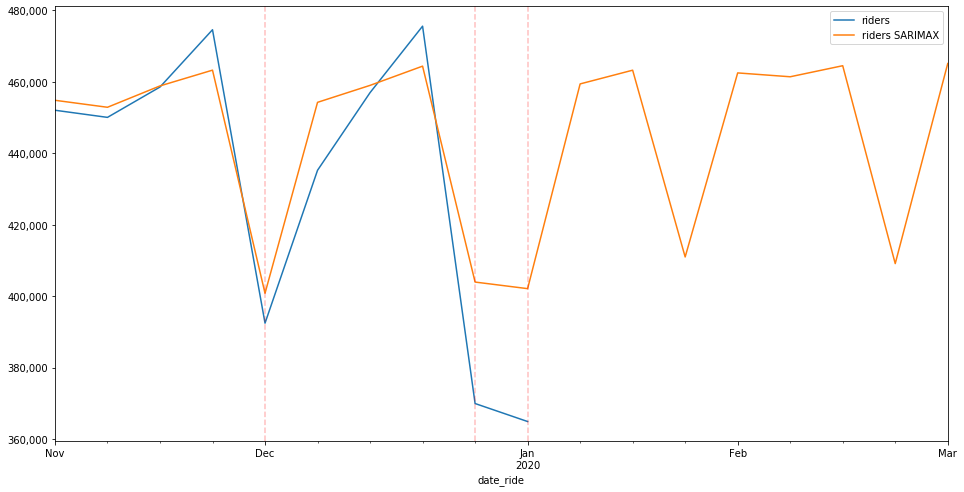

In [40]:
ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [41]:
compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

In [42]:
ts.error_calcs(compare, predictions, test[series])

In [43]:
intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [44]:
intervals

In [45]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

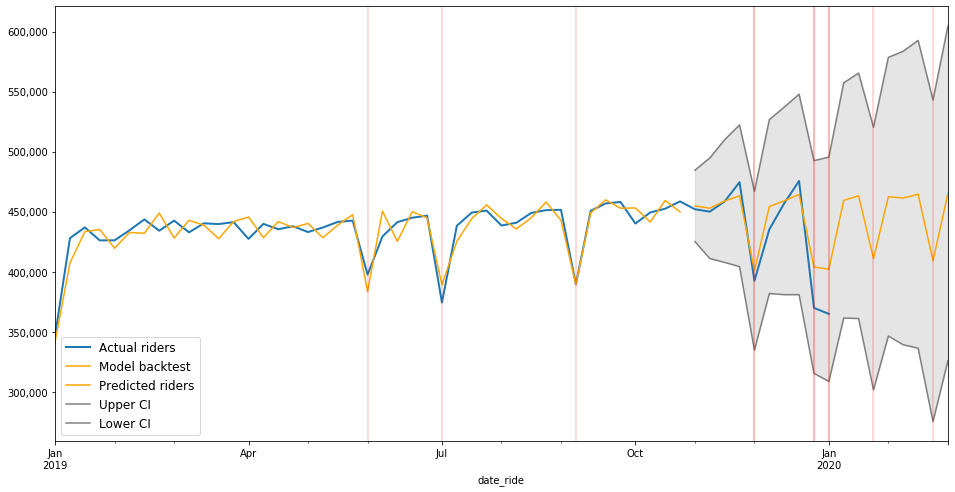

In [46]:
ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

# Reset Training and Exog for OOS Modeling

In [47]:
# set up for forecasting and backtesting
# set the ranges
train = wdf.copy()

end = len(train)

train.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-12-08        0       894311    597287 18,437,779.14   7316081   
2019-12-15        0       940555    631977 19,384,119.78   7751444   
2019-12-22        0       979626    647587 19,845,284.49   7886544   
2019-12-29        1       757684    379783 11,712,788.29   4341018   
2020-01-05        1       748943    389129 12,022,569.19   4747596   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-12-08               744867        12,904,658.26         9,181,793.00   
2019-12-15               786697        13,724,890.57         9,708,663.00   
2019-12-22               815841        13,970,148.04        10,015,541.00   
2019-12-29               609493         7,859,343.38         6,874,595.00   
2020-01-05               608516         8,302,625.03         7,198,940.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-12-08               15345        1,685,154.72          143,221.00   
2019-12-15               15909        1,737,038.44          154,132.00   
2019-12-22               17190        1,782,864.93          158,321.00   
2019-12-29               16269        1,242,512.94          125,732.00   
2020-01-05               15527        1,157,859.82          131,761.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-12-08               134099         3,847,966.16         1,236,383.00   
2019-12-15               137949         3,922,190.77         1,263,143.00   
2019-12-22               146595         4,092,271.52         1,329,721.00   
2019-12-29               131922         2,610,931.97         1,058,773.00   
2020-01-05               124900         2,562,084.34         1,049,901.00   

            riders  cpm  
date_ride                
2019-12-08  435241 2.52  
2019-12-15  456976 2.50  
2019-12-22  475574 2.52  
2019-12-29  369957 2.70  
2020-01-05  364918 2.53

In [48]:
# reset the exogenous series
# roll forward what has occurred
# reset the horizon from 18 to 9.

roll_fwd = 9

short_horizon = 9

short_exog = oos_exog.iloc[roll_fwd:roll_fwd + short_horizon]

short_exog

holiday
date               
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        1
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        1
2020-03-01        0

# Gross Rides - OOS

In [49]:
series = 'gross_rides'

In [50]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  314
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood               -3577.183
Date:                            Fri, 31 Jan 2020   AIC                           7168.367
Time:                                    13:32:10   BIC                           7194.317
Sample:                                01-05-2014   HQIC                          7178.751
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.143e+05   3067.098    -37.254      0.000    -1.2e+05   -1.08e+05
ar.L1          0.2520      0.011     22.466      0.000       0.230       0.274
ar.L2         -0.9881      0.011    -87.647      0.000      -1.010      -0.966
ma.L1         -0.2550      0.024    -10.810      0.000      -0.301      -0.209
ma.L2          0.9557      0.023     40.678      0.000       0.910       1.002
ar.S.L12      -0.3924      0.014    -27.104      0.000      -0.421      -0.364
sigma2      1.003e+09      0.033   3.08e+10      0.000       1e+09       1e+09
===================================================================================
Ljung-Box (Q):                      102.74   Jarque-Bera (JB):               424.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.27e+25. Standard errors may be unstable.
"""

In [51]:
ts.get_dw(model)

1.4162938163865024

In [52]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

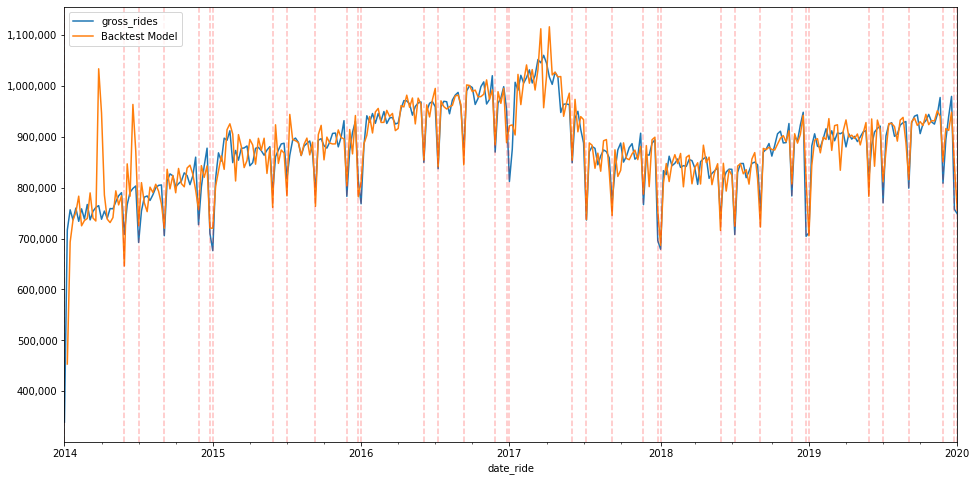

In [53]:
# plot model backtest

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [54]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [55]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [56]:
intervals

In [57]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

In [58]:
# make the final df for merging

gross_rides_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = True)

gross_rides_fcast

gross_rides  lower_gross_rides  upper_gross_rides  fcast_date
2020-01-12   755,680.08         693,601.39         817,758.77  2020-01-31
2020-01-19   889,526.43         801,867.85         977,185.01  2020-01-31
2020-01-26   886,292.36         780,161.60         992,423.12  2020-01-31
2020-02-02   755,059.23         633,387.89         876,730.57  2020-01-31
2020-02-09   872,979.80         736,671.32       1,009,288.29  2020-01-31
2020-02-16   913,126.37         763,268.46       1,062,984.27  2020-01-31
2020-02-23   887,673.48         726,046.10       1,049,300.87  2020-01-31
2020-03-01   746,429.75         574,265.61         918,593.89  2020-01-31
2020-03-08   876,214.55         693,665.75       1,058,763.35  2020-01-31

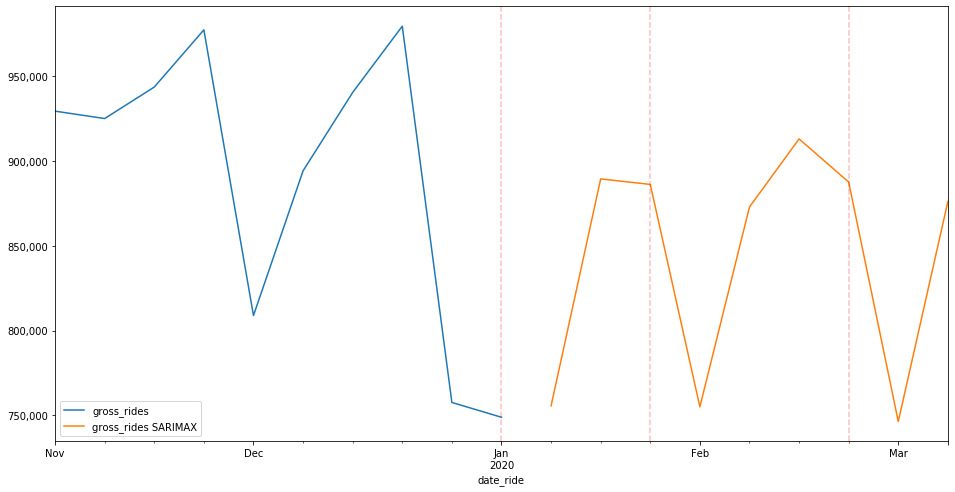

In [59]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=short_exog,
                   vp=False)

# Riders - OOS

In [60]:
series = 'riders'

In [61]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  314
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood               -3356.316
Date:                            Fri, 31 Jan 2020   AIC                           6726.631
Time:                                    13:33:00   BIC                           6752.581
Sample:                                01-05-2014   HQIC                          6737.015
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.548e+04   1470.014    -37.741      0.000   -5.84e+04   -5.26e+04
ar.L1          0.2356      0.006     41.998      0.000       0.225       0.247
ar.L2         -0.9919      0.006   -164.769      0.000      -1.004      -0.980
ma.L1         -0.1999      0.010    -19.145      0.000      -0.220      -0.179
ma.L2          0.9950      0.036     27.864      0.000       0.925       1.065
ar.S.L12      -0.3795      0.016    -23.451      0.000      -0.411      -0.348
sigma2      2.263e+08      0.011    2.1e+10      0.000    2.26e+08    2.26e+08
===================================================================================
Ljung-Box (Q):                      115.18   Jarque-Bera (JB):               331.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+26. Standard errors may be unstable.
"""

In [62]:
ts.get_dw(model)

1.4586713703843355

In [63]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

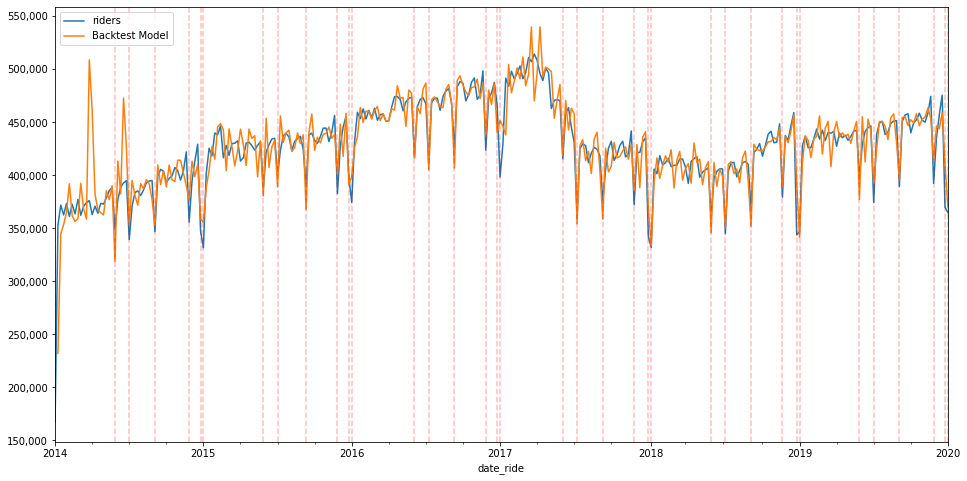

In [64]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [65]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [66]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [67]:
intervals

In [68]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

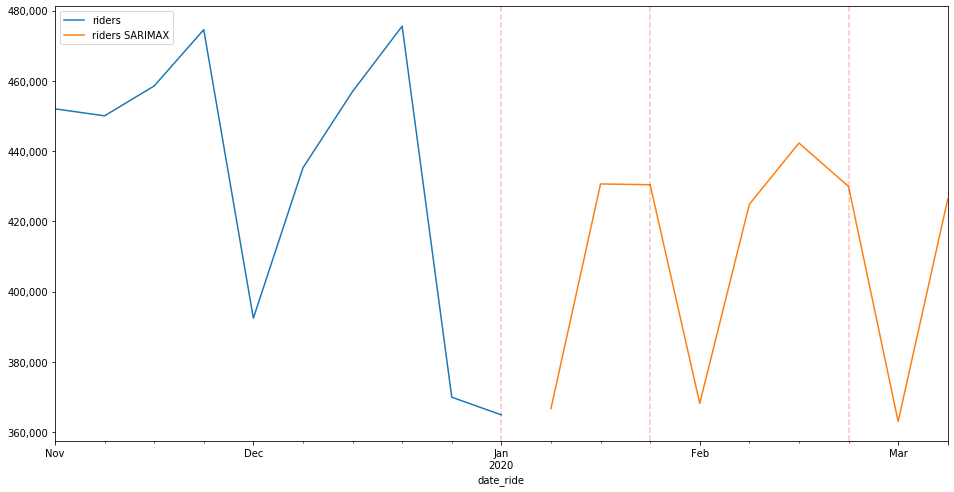

In [69]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=short_exog,
                   vp=False)

In [70]:
# make the final df for merging

riders_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = False)

riders_fcast

riders  lower_riders  upper_riders
2020-01-12 366,720.13    337,202.98    396,237.28
2020-01-19 430,661.06    388,160.28    473,161.84
2020-01-26 430,437.39    377,918.99    482,955.78
2020-02-02 368,198.35    307,782.91    428,613.79
2020-02-09 424,877.96    357,706.42    492,049.50
2020-02-16 442,303.96    368,647.12    515,960.80
2020-02-23 429,937.13    350,051.89    509,822.37
2020-03-01 363,024.78    277,609.19    448,440.37
2020-03-08 426,347.22    336,021.38    516,673.07

# Begin VP Series

## Reset Values for VP Train

In [71]:
# set the ranges

# make the training set
train = vpdf.copy()

# set the end point
end = len(train)

# set the truncation point to excude vp lag
print(vp_lag_wks)

train.tail()

10


holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-09-29        0       943292    656406 20,095,565.17   8058659   
2019-10-06        0       906442    621515 19,256,099.12   7659789   
2019-10-13        0       925897    638999 19,607,886.31   7837903   
2019-10-20        0       932062    638441 19,546,977.09   7798647   
2019-10-27        0       944285    655256 19,998,949.72   7992527   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-09-29               789281        14,135,937.04         9,796,333.00   
2019-10-06               755293        13,439,320.38         9,388,865.00   
2019-10-13               772670        13,742,240.80         9,591,852.00   
2019-10-20               778819        13,707,582.71         9,608,075.00   
2019-10-27               789892        14,065,021.51         9,746,398.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-09-29               15959        1,864,200.66          151,257.00   
2019-10-06               15769        1,848,272.82          154,847.00   
2019-10-13               16094        1,886,898.17          153,994.00   
2019-10-20               15854        1,834,207.50          149,091.00   
2019-10-27               15775        1,867,789.80          150,079.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-09-29               138052         4,095,427.47         1,287,620.00   
2019-10-06               135380         3,968,505.92         1,248,504.00   
2019-10-13               137133         3,978,747.34         1,254,662.00   
2019-10-20               137389         4,005,186.88         1,262,448.00   
2019-10-27               138618         4,066,138.41         1,278,256.00   

            riders  cpm  
date_ride                
2019-09-29  458096 2.49  
2019-10-06  440156 2.51  
2019-10-13  449387 2.50  
2019-10-20  452486 2.51  
2019-10-27  458569 2.50

In [72]:
# reset exog

oos_exog = oos.iloc[:horizon]

oos_exog

holiday
date               
2019-11-03        0
2019-11-10        0
2019-11-17        0
2019-11-24        0
2019-12-01        1
2019-12-08        0
2019-12-15        0
2019-12-22        0
2019-12-29        1
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        1
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        1
2020-03-01        0

# Ver Pd Rides

In [73]:
series = 'vp_rides'

In [74]:
model = ts.build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_rides   No. Observations:                  304
Model:             SARIMAX(1, 0, 1)x(2, 1, 0, 5)   Log Likelihood               -3487.725
Date:                           Fri, 31 Jan 2020   AIC                           6987.449
Time:                                   13:37:10   BIC                           7009.652
Sample:                               01-05-2014   HQIC                          6996.336
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.339e+05   3433.215    -38.987      0.000   -1.41e+05   -1.27e+05
ar.L1          0.8987      0.018     50.704      0.000       0.864       0.933
ma.L1         -0.7258      0.039    -18.427      0.000      -0.803      -0.649
ar.S.L5       -0.4379      0.047     -9.273      0.000      -0.530      -0.345
ar.S.L10      -0.1653      0.045     -3.683      0.000      -0.253      -0.077
sigma2      9.342e+08      0.015   6.35e+10      0.000    9.34e+08    9.34e+08
===================================================================================
Ljung-Box (Q):                       55.28   Jarque-Bera (JB):                54.29
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.47
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+26. Standard errors may be unstable.
"""

In [75]:
ts.get_dw(model)

0.7404237179007862

In [76]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

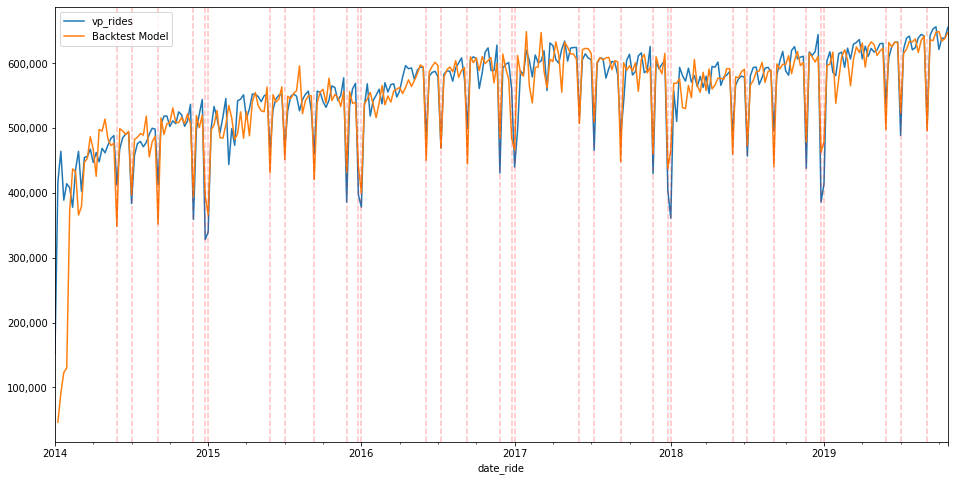

In [77]:
# plot backtest

ts.plot_fit(train[series], backtest, train);

In [78]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [79]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [80]:
intervals

In [81]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

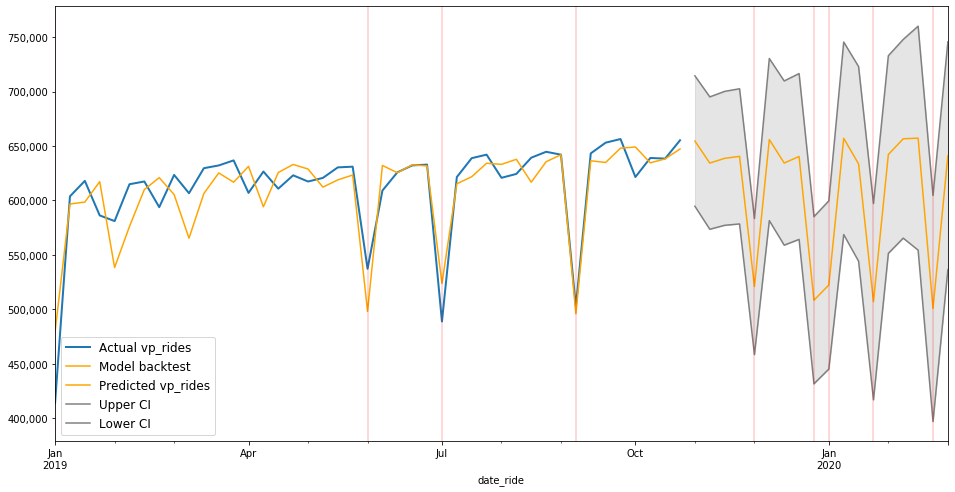

In [82]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [83]:
# make final series

vp_rides = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_rides

vp_rides  lower_vp_rides  upper_vp_rides
2019-11-03 654,561.24      594,656.24      714,466.24
2019-11-10 634,320.10      573,526.23      695,113.96
2019-11-17 638,680.01      577,177.68      700,182.34
2019-11-24 640,499.44      578,430.87      702,568.02
2019-12-01 520,933.29      458,411.16      583,455.42
2019-12-08 655,924.58      581,468.92      730,380.24
2019-12-15 634,343.52      558,943.93      709,743.11
2019-12-22 640,381.50      564,228.14      716,534.86
2019-12-29 508,344.54      431,587.85      585,101.23
2020-01-05 522,401.18      445,160.69      599,641.68
2020-01-12 657,092.39      568,682.74      745,502.03
2020-01-19 633,528.20      544,158.14      722,898.26
2020-01-26 507,016.73      416,878.51      597,154.95
2020-02-02 642,172.25      551,418.43      732,926.08
2020-02-09 656,639.84      565,391.89      747,887.80
2020-02-16 657,211.26      554,375.94      760,046.57
2020-02-23 500,798.81      396,962.30      604,635.31
2020-03-01 641,064.73      536,426.67      745,702.80

# Ver Pd Costs

In [84]:
series = 'vp_costs'

In [85]:
model = ts.build_model(train[series],
                       p=2,
                       d=0,
                       q=0,
                       S=2,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_costs   No. Observations:                  304
Model:             SARIMAX(2, 0, 0)x(2, 1, 1, 2)   Log Likelihood               -4522.711
Date:                           Fri, 31 Jan 2020   AIC                           9059.423
Time:                                   13:37:18   BIC                           9085.396
Sample:                               01-05-2014   HQIC                          9069.815
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -3.75e+06   2.96e-09  -1.27e+15      0.000   -3.75e+06   -3.75e+06
ar.L1          0.5170      0.033     15.499      0.000       0.452       0.582
ar.L2          0.4770      0.034     14.064      0.000       0.411       0.544
ar.S.L2       -0.2736      0.033     -8.309      0.000      -0.338      -0.209
ar.S.L4       -0.1269      0.056     -2.278      0.023      -0.236      -0.018
ma.S.L2       -0.9776      0.026    -37.838      0.000      -1.028      -0.927
sigma2      6.514e+11   2.82e-14   2.31e+25      0.000    6.51e+11    6.51e+11
===================================================================================
Ljung-Box (Q):                       47.83   Jarque-Bera (JB):               191.43
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.16
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+40. Standard errors may be unstable.
"""

In [86]:
ts.get_dw(model)

1.3488160916279692

In [87]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

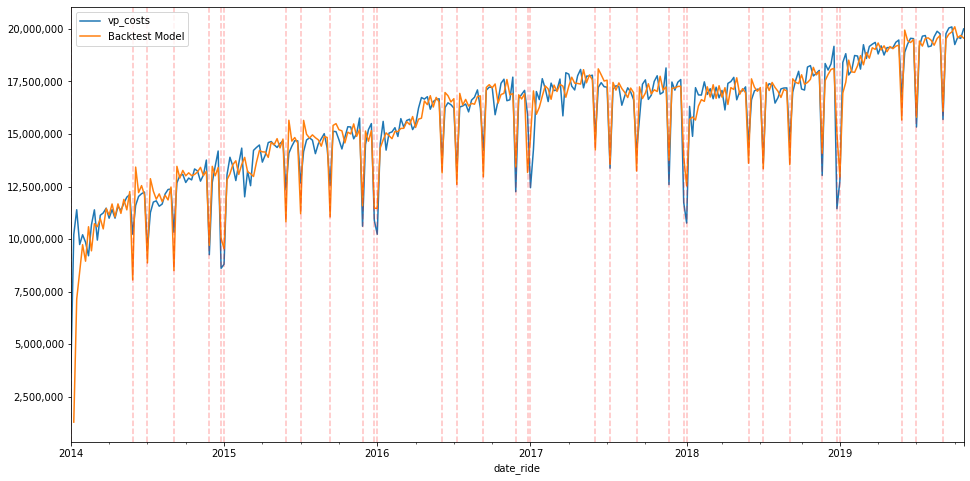

In [88]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [89]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [90]:
# make prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [91]:
intervals

In [92]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

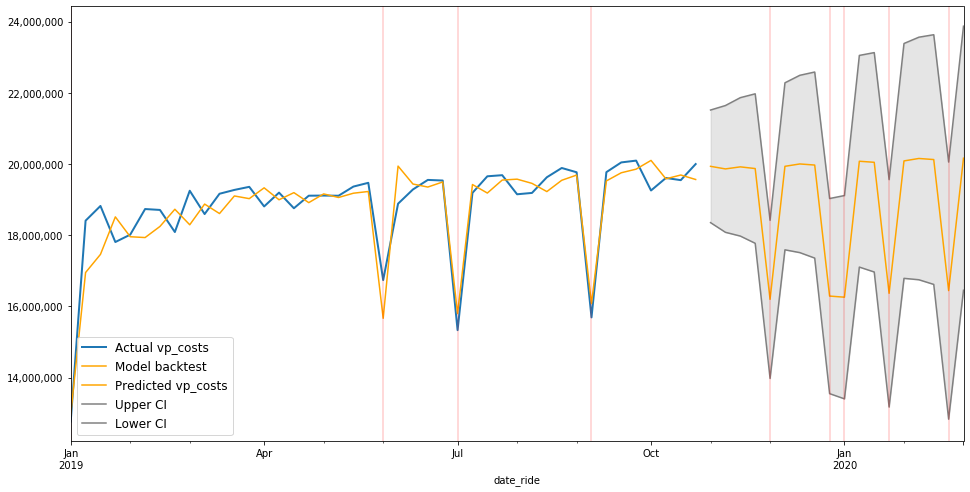

In [93]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [94]:
# make final series

vp_costs = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_costs

vp_costs  lower_vp_costs  upper_vp_costs
2019-11-03 19,935,075.69   18,353,158.90   21,516,992.48
2019-11-10 19,862,346.15   18,081,547.31   21,643,144.99
2019-11-17 19,920,053.36   17,975,928.85   21,864,177.87
2019-11-24 19,872,694.49   17,772,934.78   21,972,454.20
2019-12-01 16,197,706.61   13,976,074.05   18,419,339.17
2019-12-08 19,935,586.67   17,589,618.06   22,281,555.27
2019-12-15 20,001,772.61   17,510,924.87   22,492,620.35
2019-12-22 19,971,030.33   17,357,227.13   22,584,833.54
2019-12-29 16,289,870.62   13,549,324.39   19,030,416.84
2020-01-05 16,258,258.79   13,402,271.81   19,114,245.78
2020-01-12 20,077,862.79   17,104,541.28   23,051,184.31
2020-01-19 20,048,337.88   16,966,405.63   23,130,270.14
2020-01-26 16,367,326.18   13,172,374.89   19,562,277.48
2020-02-02 20,087,044.60   16,787,978.69   23,386,110.50
2020-02-09 20,155,910.68   16,748,558.12   23,563,263.24
2020-02-16 20,125,342.37   16,617,696.15   23,632,988.58
2020-02-23 16,444,116.57   12,832,114.66   20,056,118.48
2020-03-01 20,163,494.86   16,454,456.56   23,872,533.16

# Ver Pd Miles

In [95]:
series = 'vp_miles'

In [96]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_miles   No. Observations:                  304
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 5)   Log Likelihood               -4382.572
Date:                           Fri, 31 Jan 2020   AIC                           8777.145
Time:                                   13:40:02   BIC                           8799.327
Sample:                               01-05-2014   HQIC                          8786.024
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.505e+06   7.17e+04    -21.003      0.000   -1.65e+06   -1.36e+06
ar.L1          0.1688      0.078      2.169      0.030       0.016       0.321
ma.L1         -0.6921      0.071     -9.771      0.000      -0.831      -0.553
ar.S.L5       -0.5633      0.037    -15.367      0.000      -0.635      -0.491
ar.S.L10      -0.2882      0.040     -7.192      0.000      -0.367      -0.210
sigma2      4.239e+11      0.194   2.19e+12      0.000    4.24e+11    4.24e+11
===================================================================================
Ljung-Box (Q):                       69.33   Jarque-Bera (JB):              2481.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+27. Standard errors may be unstable.
"""

In [97]:
ts.get_dw(model)

1.6367720913949368

In [98]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

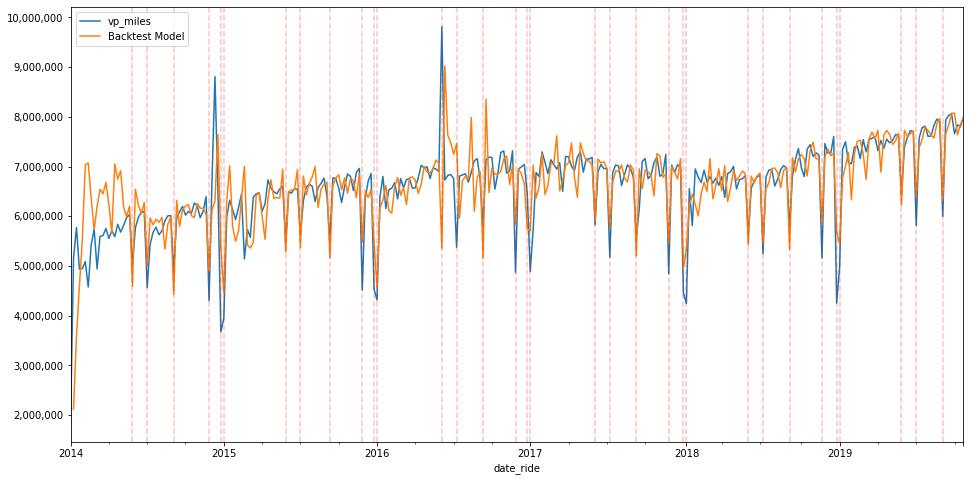

In [99]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [100]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [101]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [102]:
intervals

In [103]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

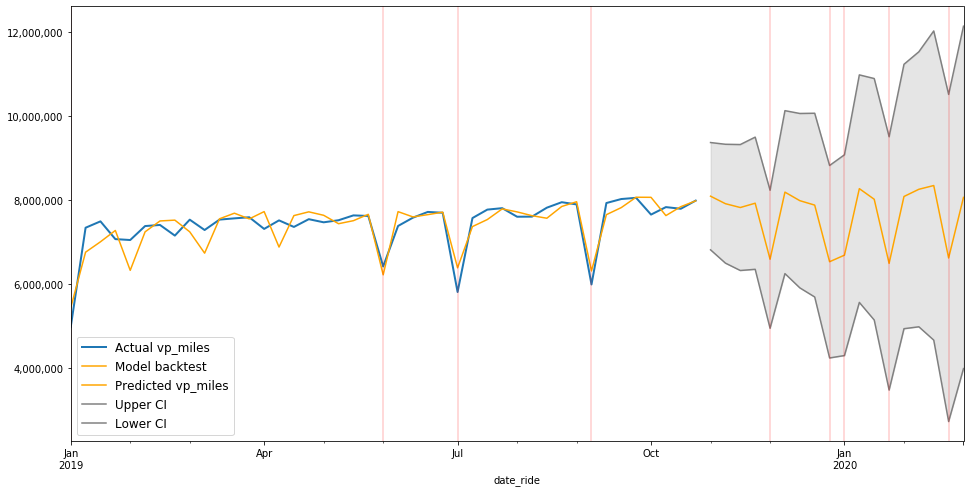

In [104]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [105]:
# make final series

vp_miles = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_miles

vp_miles  lower_vp_miles  upper_vp_miles
2019-11-03 8,097,899.33    6,821,787.26    9,374,011.41
2019-11-10 7,918,997.16    6,505,313.27    9,332,681.05
2019-11-17 7,828,118.50    6,330,087.36    9,326,149.64
2019-11-24 7,930,480.76    6,358,478.16    9,502,483.36
2019-12-01 6,597,756.76    4,956,039.54    8,239,473.98
2019-12-08 8,194,229.49    6,256,089.72   10,132,369.26
2019-12-15 7,991,237.76    5,917,212.80   10,065,262.72
2019-12-22 7,885,414.79    5,699,901.61   10,070,927.97
2019-12-29 6,538,856.71    4,249,759.43    8,827,953.99
2020-01-05 6,694,873.98    4,307,080.91    9,082,667.05
2020-01-12 8,277,097.35    5,570,891.44   10,983,303.25
2020-01-19 8,024,278.45    5,152,012.99   10,896,543.90
2020-01-26 6,499,360.31    3,486,399.73    9,512,320.89
2020-02-02 8,090,453.96    4,945,633.15   11,235,274.77
2020-02-09 8,261,865.83    4,990,907.34   11,532,824.32
2020-02-16 8,351,094.38    4,673,915.03   12,028,273.74
2020-02-23 6,628,246.09    2,737,460.39   10,519,031.80
2020-03-01 8,069,302.52    3,996,939.07   12,141,665.96

# Ver Pd Amb Rides

In [106]:
series = 'vp_ambulatory_rides'

In [107]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_rides   No. Observations:                  304
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 4)   Log Likelihood               -3464.258
Date:                           Fri, 31 Jan 2020   AIC                           6944.516
Time:                                   13:40:26   BIC                           6974.120
Sample:                               01-05-2014   HQIC                          6956.365
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -9.635e+04   3035.139    -31.745      0.000   -1.02e+05   -9.04e+04
ar.L1         -0.9183      0.081    -11.369      0.000      -1.077      -0.760
ar.L2         -0.1141      0.037     -3.058      0.002      -0.187      -0.041
ma.L1          0.9199      0.088     10.484      0.000       0.748       1.092
ar.S.L4        0.3601      0.058      6.177      0.000       0.246       0.474
ar.S.L8        0.0630      0.040      1.574      0.115      -0.015       0.141
ma.S.L4       -0.9401      0.045    -20.749      0.000      -1.029      -0.851
sigma2      7.467e+08      0.054   1.38e+10      0.000    7.47e+08    7.47e+08
===================================================================================
Ljung-Box (Q):                       97.02   Jarque-Bera (JB):               709.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -1.38
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.53e+25. Standard errors may be unstable.
"""

In [108]:
ts.get_dw(model)

1.1667805338514574

In [109]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

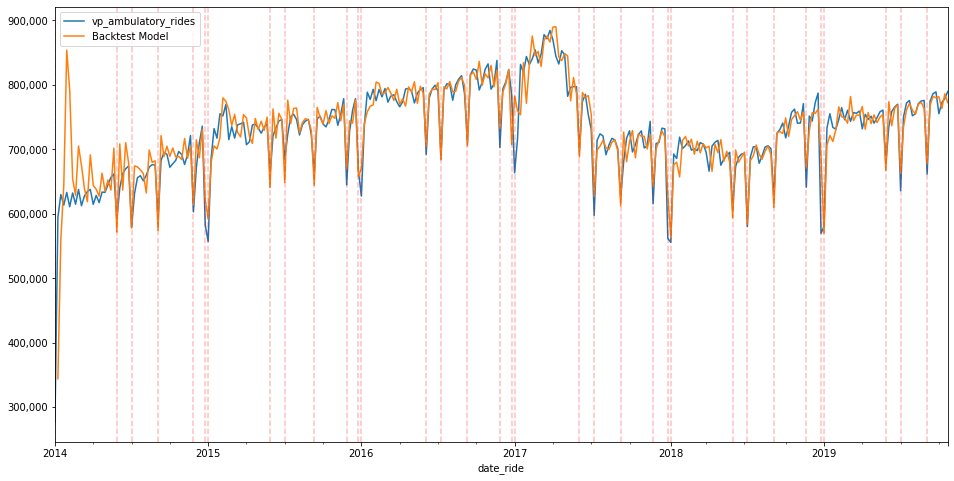

In [110]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [111]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [112]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [113]:
intervals

In [114]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

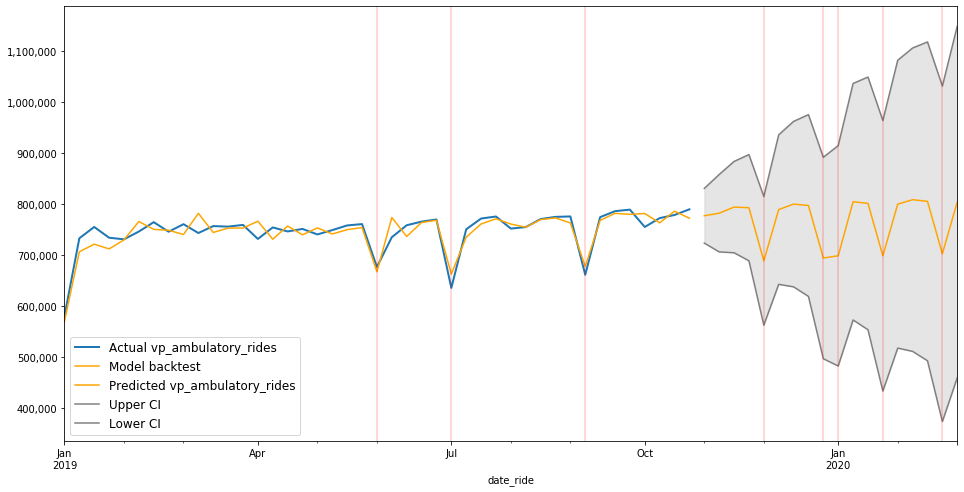

In [115]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [116]:
# make final series

vp_ambulatory_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_rides

vp_ambulatory_rides  lower_vp_ambulatory_rides  \
2019-11-03           777,282.82                 723,724.09   
2019-11-10           782,283.57                 706,478.07   
2019-11-17           794,254.37                 704,819.30   
2019-11-24           793,086.66                 689,060.27   
2019-12-01           688,949.07                 562,934.50   
2019-12-08           789,350.34                 642,886.07   
2019-12-15           800,106.53                 638,050.44   
2019-12-22           797,363.94                 619,289.76   
2019-12-29           694,513.35                 497,189.59   
2020-01-05           698,827.11                 482,881.49   
2020-01-12           804,796.64                 573,106.00   
2020-01-19           801,537.07                 554,012.77   
2020-01-26           698,821.18                 433,851.71   
2020-02-02           800,006.77                 518,020.20   
2020-02-09           808,765.34                 511,567.57   
2020-02-16           805,509.34                 493,178.09   
2020-02-23           702,700.50                 374,122.44   
2020-03-01           804,261.89                 459,806.79   

            upper_vp_ambulatory_rides  
2019-11-03                 830,841.54  
2019-11-10                 858,089.07  
2019-11-17                 883,689.43  
2019-11-24                 897,113.06  
2019-12-01                 814,963.65  
2019-12-08                 935,814.60  
2019-12-15                 962,162.62  
2019-12-22                 975,438.11  
2019-12-29                 891,837.11  
2020-01-05                 914,772.74  
2020-01-12               1,036,487.28  
2020-01-19               1,049,061.36  
2020-01-26                 963,790.65  
2020-02-02               1,081,993.35  
2020-02-09               1,105,963.12  
2020-02-16               1,117,840.59  
2020-02-23               1,031,278.56  
2020-03-01               1,148,716.99

# Ver Pd Amb Costs

In [117]:
series = 'vp_ambulatory_costs'

In [118]:
model = ts.build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_costs   No. Observations:                  304
Model:             SARIMAX(1, 0, 1)x(2, 1, 0, 5)   Log Likelihood               -4396.614
Date:                           Fri, 31 Jan 2020   AIC                           8805.227
Time:                                   13:41:17   BIC                           8827.430
Sample:                               01-05-2014   HQIC                          8814.114
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.768e+06   7.44e+04    -37.191      0.000   -2.91e+06   -2.62e+06
ar.L1          0.9108      0.020     46.079      0.000       0.872       0.950
ma.L1         -0.7527      0.047    -16.026      0.000      -0.845      -0.661
ar.S.L5       -0.4499      0.049     -9.184      0.000      -0.546      -0.354
ar.S.L10      -0.1893      0.048     -3.936      0.000      -0.284      -0.095
sigma2      4.161e+11      0.003    1.6e+14      0.000    4.16e+11    4.16e+11
===================================================================================
Ljung-Box (Q):                       58.48   Jarque-Bera (JB):                29.14
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.40
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.47e+30. Standard errors may be unstable.
"""

In [119]:
ts.get_dw(model)

0.8372963354380629

In [120]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

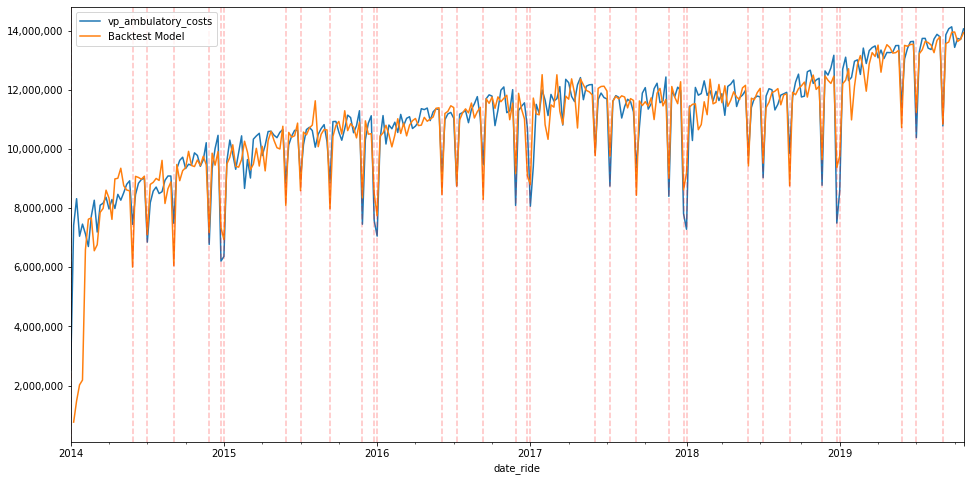

In [121]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [122]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [123]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [124]:
intervals

In [125]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

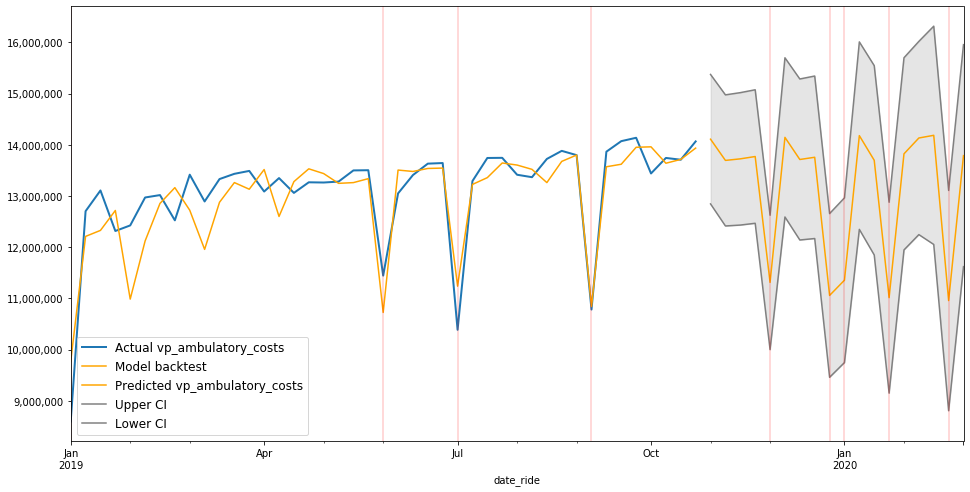

In [126]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [127]:
# make final series

vp_ambulatory_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_costs

vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2019-11-03        14,108,652.16              12,844,346.31   
2019-11-10        13,694,029.70              12,414,022.84   
2019-11-17        13,724,522.16              12,431,635.33   
2019-11-24        13,769,958.74              12,466,484.00   
2019-12-01        11,311,828.65               9,999,635.61   
2019-12-08        14,143,971.46              12,589,693.00   
2019-12-15        13,712,171.97              12,140,195.95   
2019-12-22        13,755,327.14              12,168,820.03   
2019-12-29        11,057,450.67               9,458,989.64   
2020-01-05        11,355,201.60               9,746,891.72   
2020-01-12        14,177,987.74              12,347,578.11   
2020-01-19        13,696,541.32              11,847,759.41   
2020-01-26        11,013,841.73               9,149,956.66   
2020-02-02        13,822,532.58              11,946,211.04   
2020-02-09        14,131,750.34              12,245,174.43   
2020-02-16        14,184,039.22              12,052,927.75   
2020-02-23        10,957,584.24               8,806,647.74   
2020-03-01        13,787,395.32              11,620,150.72   

            upper_vp_ambulatory_costs  
2019-11-03              15,372,958.01  
2019-11-10              14,974,036.55  
2019-11-17              15,017,408.99  
2019-11-24              15,073,433.48  
2019-12-01              12,624,021.68  
2019-12-08              15,698,249.92  
2019-12-15              15,284,147.99  
2019-12-22              15,341,834.24  
2019-12-29              12,655,911.69  
2020-01-05              12,963,511.49  
2020-01-12              16,008,397.37  
2020-01-19              15,545,323.22  
2020-01-26              12,877,726.80  
2020-02-02              15,698,854.13  
2020-02-09              16,018,326.26  
2020-02-16              16,315,150.68  
2020-02-23              13,108,520.74  
2020-03-01              15,954,639.92

# Ver Pd Amb Miles

In [128]:
series = 'vp_ambulatory_miles'

In [129]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_miles   No. Observations:                  304
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -4273.800
Date:                           Fri, 31 Jan 2020   AIC                           8561.599
Time:                                   13:44:01   BIC                           8587.502
Sample:                               01-05-2014   HQIC                          8571.967
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.308e+06   6.35e+04    -20.604      0.000   -1.43e+06   -1.18e+06
ar.L1         -0.8707      0.168     -5.197      0.000      -1.199      -0.542
ar.L2         -0.2169      0.039     -5.608      0.000      -0.293      -0.141
ma.L1          0.7720      0.180      4.294      0.000       0.420       1.124
ar.S.L4        0.2228      0.060      3.742      0.000       0.106       0.339
ma.S.L4       -0.9376      0.050    -18.743      0.000      -1.036      -0.840
sigma2      2.064e+11      0.067   3.07e+12      0.000    2.06e+11    2.06e+11
===================================================================================
Ljung-Box (Q):                       58.79   Jarque-Bera (JB):               841.33
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.86e+28. Standard errors may be unstable.
"""

In [130]:
ts.get_dw(model)

1.3072510899781218

In [131]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

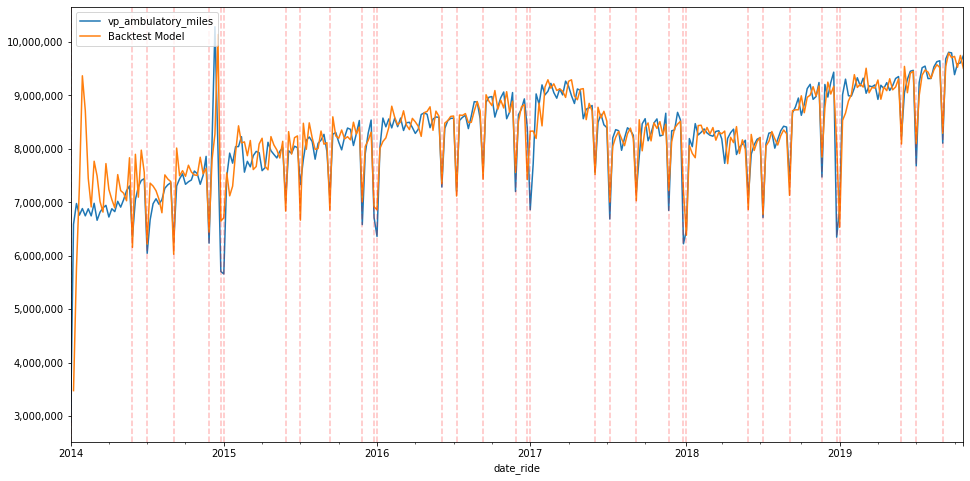

In [132]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [133]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [134]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [135]:
intervals

In [136]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

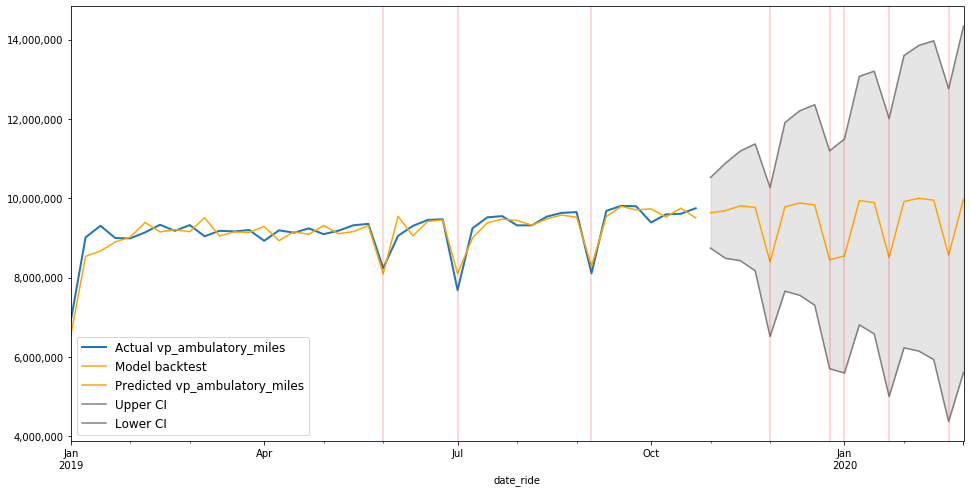

In [137]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [138]:
# make final series

vp_ambulatory_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_miles

vp_ambulatory_miles  lower_vp_ambulatory_miles  \
2019-11-03         9,632,314.42               8,741,932.23   
2019-11-10         9,684,635.20               8,485,956.29   
2019-11-17         9,808,092.58               8,427,042.03   
2019-11-24         9,769,338.44               8,170,043.44   
2019-12-01         8,391,605.92               6,515,554.40   
2019-12-08         9,782,306.27               7,656,889.50   
2019-12-15         9,878,690.63               7,552,541.08   
2019-12-22         9,831,038.88               7,303,751.08   
2019-12-29         8,447,689.94               5,701,439.81   
2020-01-05         8,543,781.45               5,594,073.86   
2020-01-12         9,939,725.26               6,806,671.45   
2020-01-19         9,890,895.50               6,579,050.51   
2020-01-26         8,506,168.64               5,002,544.37   
2020-02-02         9,913,469.77               6,228,775.22   
2020-02-09         9,999,326.11               6,145,893.46   
2020-02-16         9,950,175.20               5,931,733.98   
2020-02-23         8,565,174.33               4,369,757.97   
2020-03-01         9,973,121.70               5,608,805.02   

            upper_vp_ambulatory_miles  
2019-11-03              10,522,696.61  
2019-11-10              10,883,314.11  
2019-11-17              11,189,143.14  
2019-11-24              11,368,633.44  
2019-12-01              10,267,657.44  
2019-12-08              11,907,723.04  
2019-12-15              12,204,840.17  
2019-12-22              12,358,326.68  
2019-12-29              11,193,940.07  
2020-01-05              11,493,489.05  
2020-01-12              13,072,779.07  
2020-01-19              13,202,740.50  
2020-01-26              12,009,792.90  
2020-02-02              13,598,164.33  
2020-02-09              13,852,758.77  
2020-02-16              13,968,616.43  
2020-02-23              12,760,590.69  
2020-03-01              14,337,438.37

# Ver Pd Stretcher Rides

In [139]:
series = 'vp_stretcher_rides'

In [140]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_rides   No. Observations:                  304
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 4)   Log Likelihood               -2297.931
Date:                           Fri, 31 Jan 2020   AIC                           4611.861
Time:                                   13:44:09   BIC                           4641.465
Sample:                               01-05-2014   HQIC                          4623.710
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1515.1380     64.049    -23.656      0.000   -1640.671   -1389.605
ar.L1         -0.8618      0.119     -7.266      0.000      -1.094      -0.629
ar.L2         -0.2137      0.051     -4.157      0.000      -0.314      -0.113
ma.L1          0.8148      0.129      6.315      0.000       0.562       1.068
ar.S.L4        0.1567      0.056      2.808      0.005       0.047       0.266
ar.S.L8        0.0641      0.051      1.266      0.206      -0.035       0.163
ma.S.L4       -0.9489      0.034    -27.984      0.000      -1.015      -0.882
sigma2      2.679e+05   1.23e+04     21.858      0.000    2.44e+05    2.92e+05
===================================================================================
Ljung-Box (Q):                       42.92   Jarque-Bera (JB):               752.03
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
ts.get_dw(model)

1.0099391268048727

In [142]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

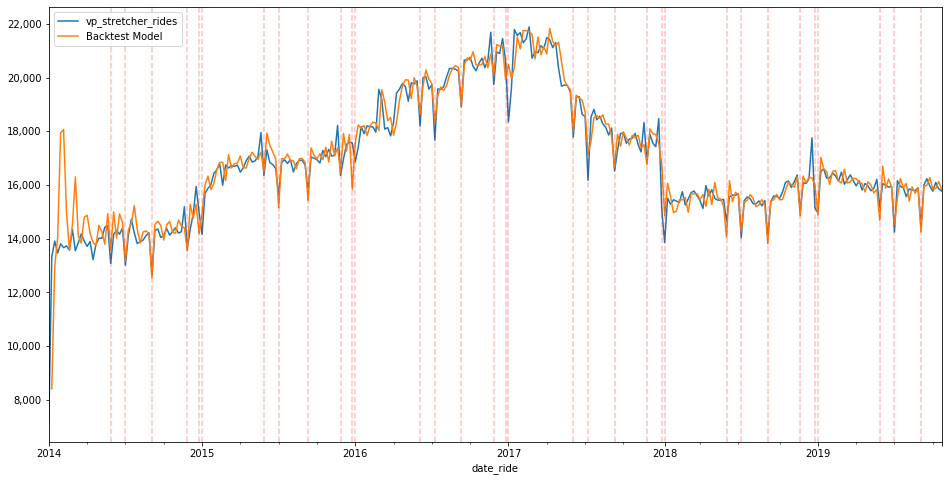

In [143]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [144]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [145]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [146]:
intervals

In [147]:
# make df for oos

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

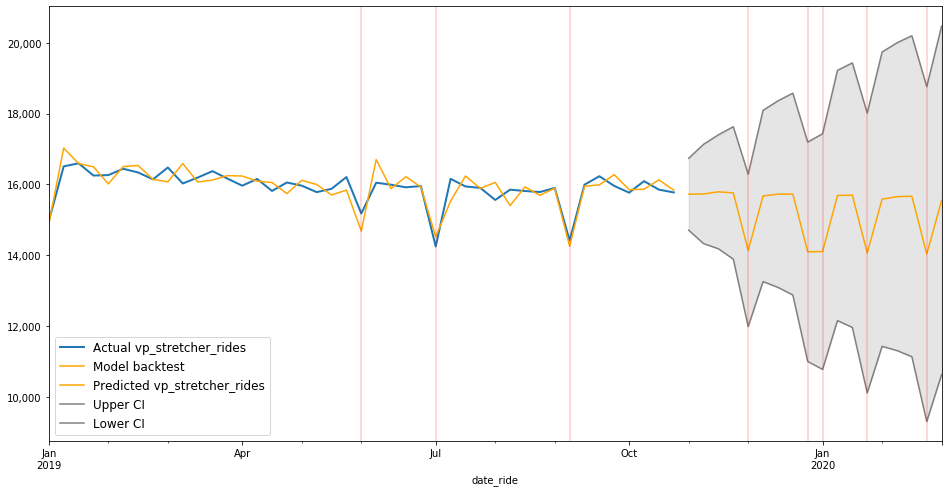

In [148]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [149]:
# make final series

vp_stretcher_rides = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_rides

vp_stretcher_rides  lower_vp_stretcher_rides  \
2019-11-03           15,724.26                 14,709.79   
2019-11-10           15,731.75                 14,330.39   
2019-11-17           15,793.32                 14,184.09   
2019-11-24           15,761.38                 13,891.29   
2019-12-01           14,139.10                 11,988.64   
2019-12-08           15,675.20                 13,257.49   
2019-12-15           15,727.11                 13,093.46   
2019-12-22           15,727.74                 12,878.46   
2019-12-29           14,100.19                 11,003.43   
2020-01-05           14,104.83                 10,777.29   
2020-01-12           15,689.18                 12,156.33   
2020-01-19           15,697.95                 11,962.86   
2020-01-26           14,066.05                 10,115.86   
2020-02-02           15,584.05                 11,428.74   
2020-02-09           15,655.41                 11,310.20   
2020-02-16           15,667.51                 11,135.99   
2020-02-23           14,034.61                  9,305.68   
2020-03-01           15,551.28                 10,632.54   

            upper_vp_stretcher_rides  
2019-11-03                 16,738.73  
2019-11-10                 17,133.11  
2019-11-17                 17,402.56  
2019-11-24                 17,631.48  
2019-12-01                 16,289.56  
2019-12-08                 18,092.92  
2019-12-15                 18,360.75  
2019-12-22                 18,577.02  
2019-12-29                 17,196.95  
2020-01-05                 17,432.36  
2020-01-12                 19,222.04  
2020-01-19                 19,433.05  
2020-01-26                 18,016.25  
2020-02-02                 19,739.36  
2020-02-09                 20,000.63  
2020-02-16                 20,199.04  
2020-02-23                 18,763.54  
2020-03-01                 20,470.01

# Ver Pd Stretcher Costs

In [150]:
series = 'vp_stretcher_costs'

In [151]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_costs   No. Observations:                  304
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 5)   Log Likelihood               -3747.587
Date:                           Fri, 31 Jan 2020   AIC                           7507.175
Time:                                   13:44:18   BIC                           7529.357
Sample:                               01-05-2014   HQIC                          7516.054
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.365e+05   1.16e+04    -20.309      0.000   -2.59e+05   -2.14e+05
ar.L1         -0.4160      0.063     -6.648      0.000      -0.539      -0.293
ar.L2         -0.2868      0.069     -4.156      0.000      -0.422      -0.152
ar.S.L5        0.1658      0.088      1.883      0.060      -0.007       0.338
ma.S.L5       -0.9230      0.056    -16.558      0.000      -1.032      -0.814
sigma2      6.697e+09      0.085   7.87e+10      0.000     6.7e+09     6.7e+09
===================================================================================
Ljung-Box (Q):                       33.89   Jarque-Bera (JB):                46.28
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.32
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+27. Standard errors may be unstable.
"""

In [152]:
ts.get_dw(model)

1.6041877098536823

In [153]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

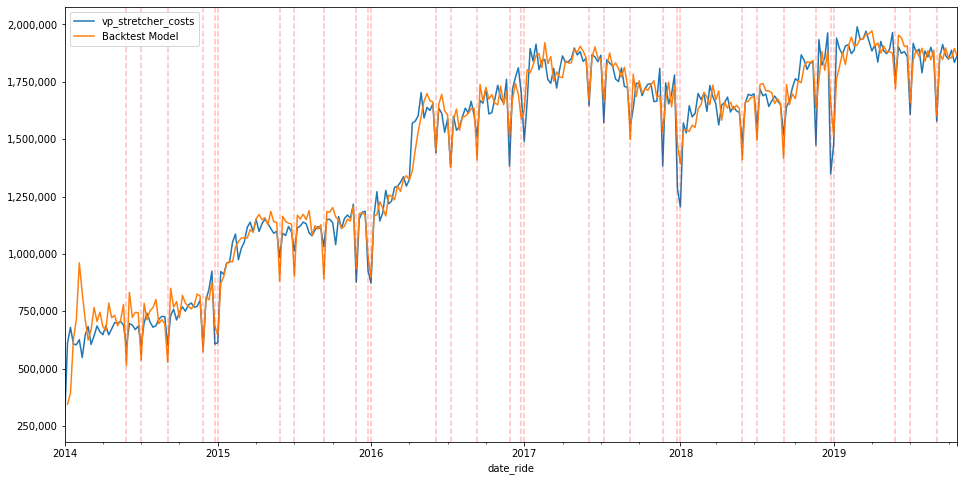

In [154]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [155]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [156]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [157]:
intervals

In [158]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

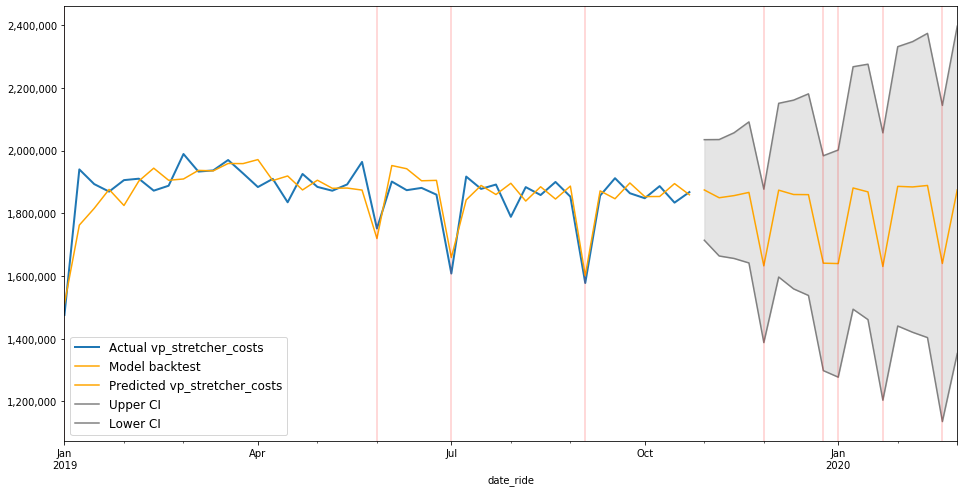

In [159]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [160]:
# make final series

vp_stretcher_costs = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_costs

vp_stretcher_costs  lower_vp_stretcher_costs  \
2019-11-03        1,874,688.55              1,714,296.91   
2019-11-10        1,849,784.93              1,664,041.74   
2019-11-17        1,856,630.53              1,656,158.33   
2019-11-24        1,866,819.37              1,641,821.90   
2019-12-01        1,632,549.31              1,387,822.06   
2019-12-08        1,874,007.51              1,596,901.10   
2019-12-15        1,860,153.57              1,559,106.94   
2019-12-22        1,859,677.70              1,538,083.58   
2019-12-29        1,641,057.68              1,298,313.48   
2020-01-05        1,639,809.44              1,277,457.68   
2020-01-12        1,881,014.46              1,494,253.94   
2020-01-19        1,868,468.61              1,461,027.78   
2020-01-26        1,630,485.32              1,203,996.05   
2020-02-02        1,886,191.20              1,440,635.66   
2020-02-09        1,884,282.44              1,420,610.46   
2020-02-16        1,888,969.32              1,403,682.05   
2020-02-23        1,640,165.97              1,135,855.87   
2020-03-01        1,874,986.67              1,352,806.18   

            upper_vp_stretcher_costs  
2019-11-03              2,035,080.19  
2019-11-10              2,035,528.13  
2019-11-17              2,057,102.73  
2019-11-24              2,091,816.84  
2019-12-01              1,877,276.55  
2019-12-08              2,151,113.93  
2019-12-15              2,161,200.20  
2019-12-22              2,181,271.82  
2019-12-29              1,983,801.88  
2020-01-05              2,002,161.20  
2020-01-12              2,267,774.97  
2020-01-19              2,275,909.44  
2020-01-26              2,056,974.58  
2020-02-02              2,331,746.75  
2020-02-09              2,347,954.42  
2020-02-16              2,374,256.59  
2020-02-23              2,144,476.06  
2020-03-01              2,397,167.16

# Ver Pd Stretcher Miles

In [161]:
series = 'vp_stretcher_miles'

In [162]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_miles   No. Observations:                  304
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 5)   Log Likelihood               -3061.426
Date:                           Fri, 31 Jan 2020   AIC                           6134.852
Time:                                   13:44:35   BIC                           6157.034
Sample:                               01-05-2014   HQIC                          6143.731
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -2.34e+04   1225.767    -19.094      0.000   -2.58e+04    -2.1e+04
ar.L1         -0.1332      0.038     -3.491      0.000      -0.208      -0.058
ar.L2         -0.1322      0.059     -2.258      0.024      -0.247      -0.017
ar.S.L5        0.2144      0.054      3.939      0.000       0.108       0.321
ma.S.L5       -0.9327      0.044    -21.421      0.000      -1.018      -0.847
sigma2      5.922e+07      0.038   1.55e+09      0.000    5.92e+07    5.92e+07
===================================================================================
Ljung-Box (Q):                       47.30   Jarque-Bera (JB):               130.42
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.47e+25. Standard errors may be unstable.
"""

In [163]:
ts.get_dw(model)

1.3342295942273836

In [164]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

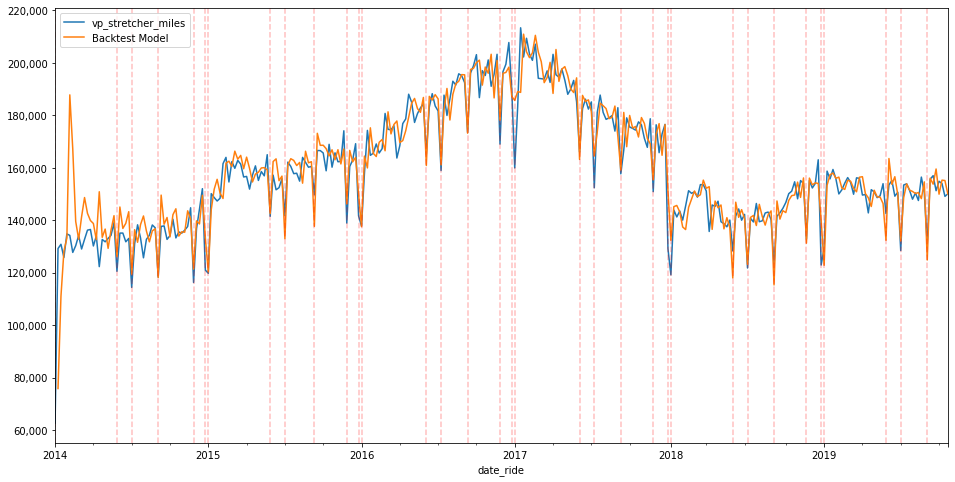

In [165]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [166]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [167]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [168]:
intervals

In [169]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

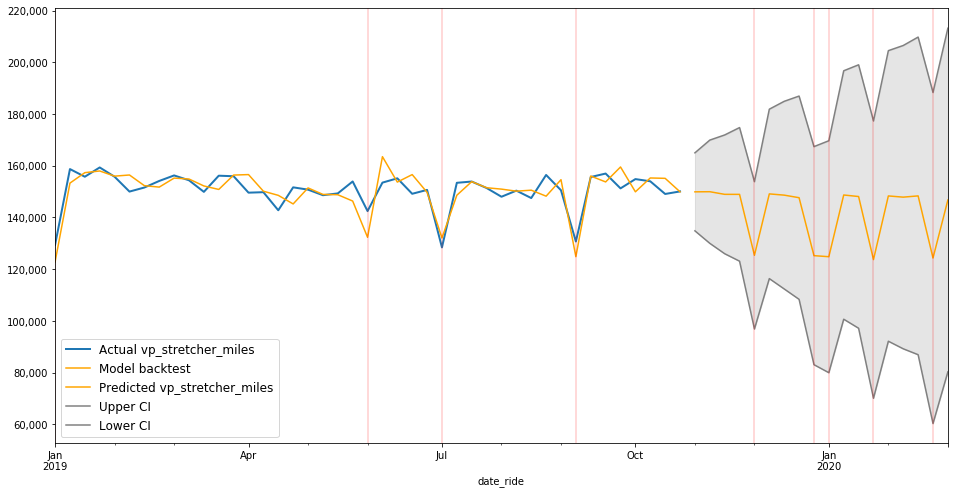

In [170]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [171]:
# make final series

vp_stretcher_miles = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_miles

vp_stretcher_miles  lower_vp_stretcher_miles  \
2019-11-03          149,919.15                134,836.66   
2019-11-10          149,965.47                130,005.72   
2019-11-17          148,949.51                125,989.99   
2019-11-24          148,938.15                123,104.43   
2019-12-01          125,368.53                 96,881.83   
2019-12-08          149,121.54                116,366.89   
2019-12-15          148,641.98                112,365.99   
2019-12-22          147,650.57                108,350.64   
2019-12-29          125,244.26                 83,086.82   
2020-01-05          124,829.67                 79,981.44   
2020-01-12          148,697.08                100,662.46   
2020-01-19          148,104.39                 97,168.88   
2020-01-26          123,712.71                 70,100.95   
2020-02-02          148,332.79                 92,153.30   
2020-02-09          147,864.70                 89,224.02   
2020-02-16          148,351.75                 86,943.19   
2020-02-23          124,329.95                 60,327.30   
2020-03-01          146,748.98                 80,297.10   

            upper_vp_stretcher_miles  
2019-11-03                165,001.65  
2019-11-10                169,925.22  
2019-11-17                171,909.03  
2019-11-24                174,771.87  
2019-12-01                153,855.24  
2019-12-08                181,876.18  
2019-12-15                184,917.97  
2019-12-22                186,950.50  
2019-12-29                167,401.70  
2020-01-05                169,677.89  
2020-01-12                196,731.69  
2020-01-19                199,039.91  
2020-01-26                177,324.48  
2020-02-02                204,512.27  
2020-02-09                206,505.38  
2020-02-16                209,760.31  
2020-02-23                188,332.60  
2020-03-01                213,200.85

# Ver Pd Wheelchair Rides

In [172]:
series = 'vp_wheelchair_rides'

In [173]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_rides   No. Observations:                  304
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2864.188
Date:                            Fri, 31 Jan 2020   AIC                           5740.376
Time:                                    13:44:53   BIC                           5762.416
Sample:                                01-05-2014   HQIC                          5749.205
                                     - 10-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.118e+04    436.418    -25.628      0.000    -1.2e+04   -1.03e+04
ar.L1          0.1344      0.024      5.576      0.000       0.087       0.182
ar.L2         -0.2050      0.049     -4.205      0.000      -0.300      -0.109
ar.S.L12      -0.4749      0.027    -17.903      0.000      -0.527      -0.423
ar.S.L24      -0.2523      0.021    -11.990      0.000      -0.293      -0.211
sigma2      2.134e+07      0.013   1.69e+09      0.000    2.13e+07    2.13e+07
===================================================================================
Ljung-Box (Q):                      126.72   Jarque-Bera (JB):               200.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.78
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+25. Standard errors may be unstable.
"""

In [174]:
ts.get_dw(model)

1.2694573582222153

In [175]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

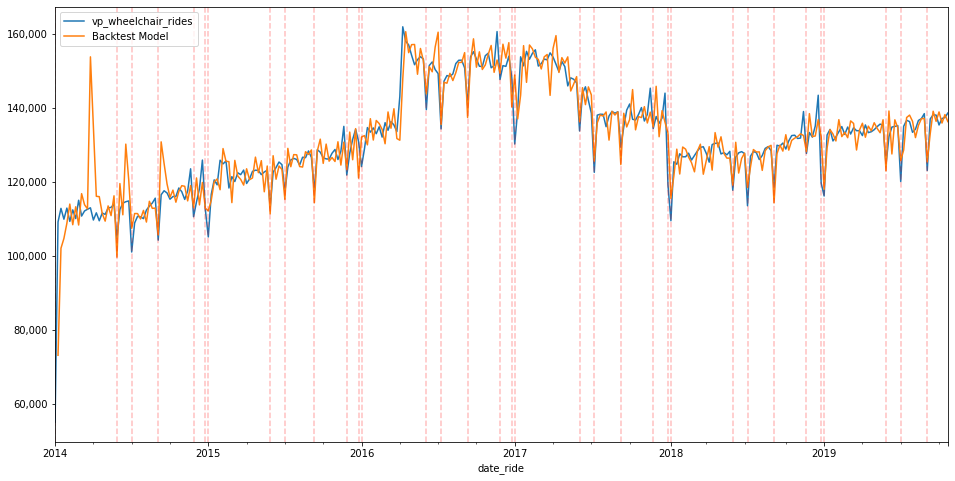

In [176]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [177]:
# predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [178]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [179]:
intervals

In [180]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

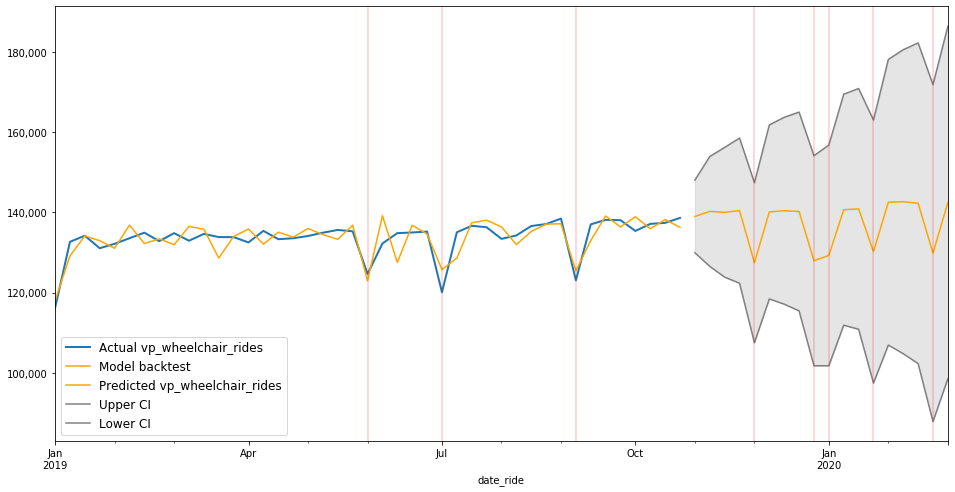

In [181]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [182]:
# make final series

vp_wheelchair_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_rides

vp_wheelchair_rides  lower_vp_wheelchair_rides  \
2019-11-03           138,985.74                 129,930.91   
2019-11-10           140,235.12                 126,542.09   
2019-11-17           140,020.90                 123,862.12   
2019-11-24           140,434.66                 122,358.21   
2019-12-01           127,449.97                 107,523.29   
2019-12-08           140,108.70                 118,436.56   
2019-12-15           140,409.91                 117,137.28   
2019-12-22           140,217.62                 115,459.03   
2019-12-29           127,944.77                 101,783.31   
2020-01-05           129,285.07                 101,789.97   
2020-01-12           140,664.96                 111,897.93   
2020-01-19           140,873.58                 110,888.93   
2020-01-26           130,242.59                  97,476.09   
2020-02-02           142,521.46                 106,947.47   
2020-02-09           142,657.76                 104,795.54   
2020-02-16           142,271.72                 102,332.30   
2020-02-23           129,858.34                  87,899.27   
2020-03-01           142,472.27                  98,565.46   

            upper_vp_wheelchair_rides  
2019-11-03                 148,040.57  
2019-11-10                 153,928.15  
2019-11-17                 156,179.68  
2019-11-24                 158,511.11  
2019-12-01                 147,376.64  
2019-12-08                 161,780.83  
2019-12-15                 163,682.54  
2019-12-22                 164,976.21  
2019-12-29                 154,106.24  
2020-01-05                 156,780.17  
2020-01-12                 169,432.00  
2020-01-19                 170,858.23  
2020-01-26                 163,009.09  
2020-02-02                 178,095.44  
2020-02-09                 180,519.98  
2020-02-16                 182,211.14  
2020-02-23                 171,817.41  
2020-03-01                 186,379.08

# Ver Pd Wheelchair Costs

In [183]:
series = 'vp_wheelchair_costs'

In [184]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_wheelchair_costs   No. Observations:                  304
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -4018.128
Date:                           Fri, 31 Jan 2020   AIC                           8048.255
Time:                                   13:45:07   BIC                           8070.417
Sample:                               01-05-2014   HQIC                          8057.127
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.872e+05   2.21e+04    -26.620      0.000    -6.3e+05   -5.44e+05
ar.L1         -0.3917      0.051     -7.657      0.000      -0.492      -0.291
ar.L2         -0.2325      0.074     -3.134      0.002      -0.378      -0.087
ar.S.L6       -0.5942      0.046    -13.033      0.000      -0.684      -0.505
ar.S.L12      -0.3041      0.040     -7.600      0.000      -0.383      -0.226
sigma2      4.183e+10      0.052   8.11e+11      0.000    4.18e+10    4.18e+10
===================================================================================
Ljung-Box (Q):                       59.97   Jarque-Bera (JB):                38.39
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.44
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.52e+26. Standard errors may be unstable.
"""

In [185]:
ts.get_dw(model)

1.4634704334759077

In [186]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

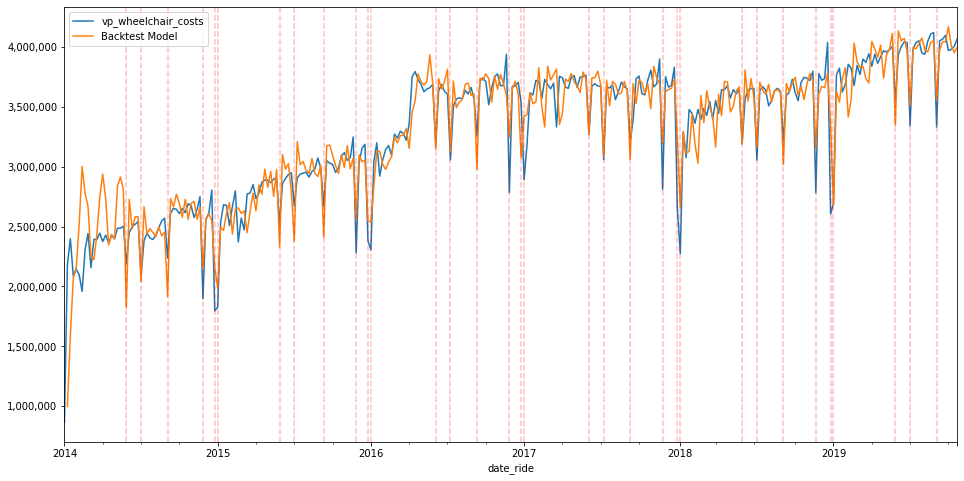

In [187]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [188]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [189]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [190]:
intervals

In [191]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

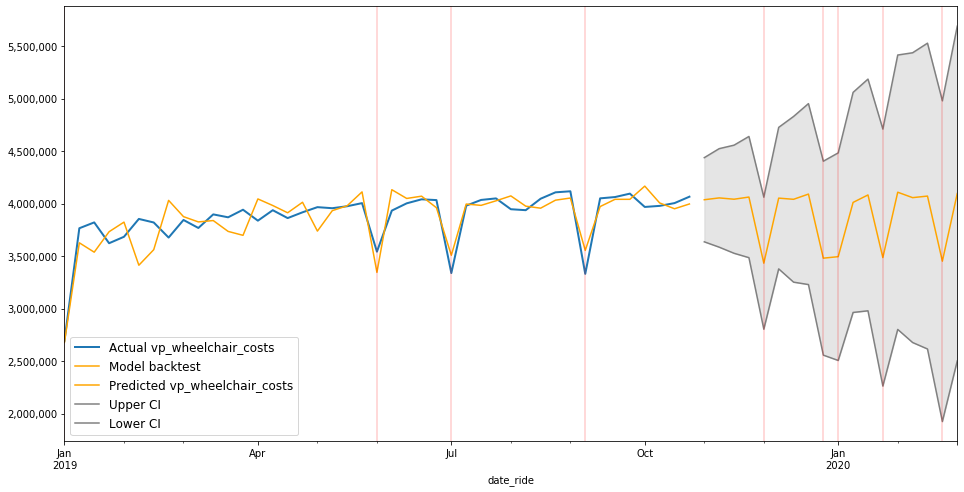

In [192]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [193]:
# make final series

vp_wheelchair_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_costs

vp_wheelchair_costs  lower_vp_wheelchair_costs  \
2019-11-03         4,037,184.05               3,636,324.70   
2019-11-10         4,054,660.25               3,585,469.30   
2019-11-17         4,042,150.70               3,527,226.28   
2019-11-24         4,062,755.22               3,485,431.47   
2019-12-01         3,432,937.62               2,804,099.51   
2019-12-08         4,052,579.99               3,378,597.79   
2019-12-15         4,041,347.35               3,252,166.45   
2019-12-22         4,091,072.49               3,229,255.69   
2019-12-29         3,480,582.73               2,556,883.78   
2020-01-05         3,494,918.05               2,506,142.72   
2020-01-12         4,011,765.80               2,963,528.31   
2020-01-19         4,082,866.66               2,979,266.49   
2020-01-26         3,486,463.61               2,262,332.95   
2020-02-02         4,108,838.24               2,801,811.66   
2020-02-09         4,057,157.38               2,677,026.33   
2020-02-16         4,072,066.54               2,615,487.03   
2020-02-23         3,452,005.46               1,924,415.07   
2020-03-01         4,095,998.58               2,501,454.30   

            upper_vp_wheelchair_costs  
2019-11-03               4,438,043.39  
2019-11-10               4,523,851.20  
2019-11-17               4,557,075.12  
2019-11-24               4,640,078.97  
2019-12-01               4,061,775.74  
2019-12-08               4,726,562.19  
2019-12-15               4,830,528.24  
2019-12-22               4,952,889.29  
2019-12-29               4,404,281.68  
2020-01-05               4,483,693.37  
2020-01-12               5,060,003.29  
2020-01-19               5,186,466.83  
2020-01-26               4,710,594.28  
2020-02-02               5,415,864.82  
2020-02-09               5,437,288.44  
2020-02-16               5,528,646.05  
2020-02-23               4,979,595.84  
2020-03-01               5,690,542.85

# Ver Pd Wheelchair Miles

In [194]:
series = 'vp_wheelchair_miles'

In [195]:
model = ts.build_model(train[series],
                       p=0,
                       d=0,
                       q=1,
                       S=12,
                       exog_data = train['holiday'],
                       P=0,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_miles   No. Observations:                  304
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -4110.032
Date:                            Fri, 31 Jan 2020   AIC                           8228.063
Time:                                    13:45:48   BIC                           8242.770
Sample:                                01-05-2014   HQIC                          8233.954
                                     - 10-27-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.761e+04   3.25e+04     -0.541      0.588   -8.14e+04    4.62e+04
ma.L1          0.1724      0.049      3.508      0.000       0.076       0.269
ma.S.L12      -0.6472      0.021    -31.559      0.000      -0.687      -0.607
sigma2      1.302e+11      0.562   2.32e+11      0.000     1.3e+11     1.3e+11
===================================================================================
Ljung-Box (Q):                       63.15   Jarque-Bera (JB):            250954.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             9.48
Prob(H) (two-sided):                  0.00   Kurtosis:                       145.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.56e+25. Standard errors may be unstable.
"""

In [196]:
ts.get_dw(model)

1.6153193993190387

In [197]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

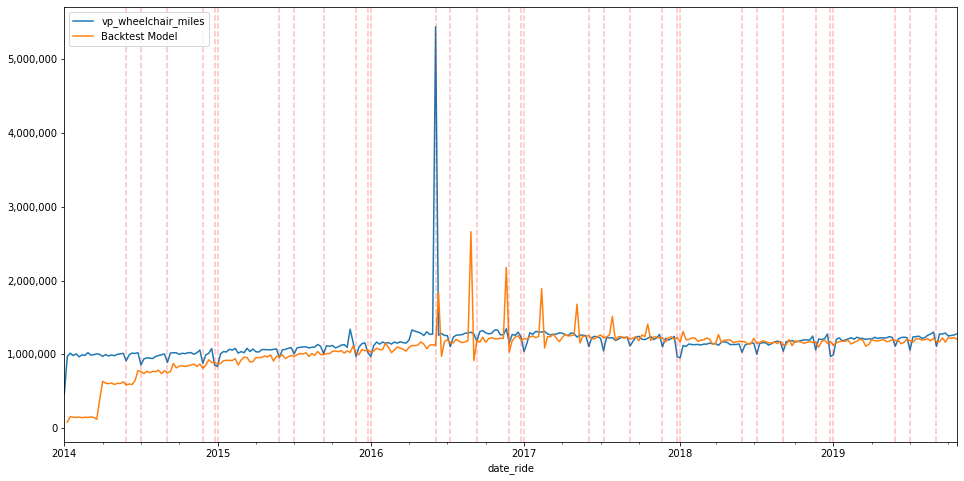

In [198]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [199]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [200]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [201]:
intervals

In [202]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

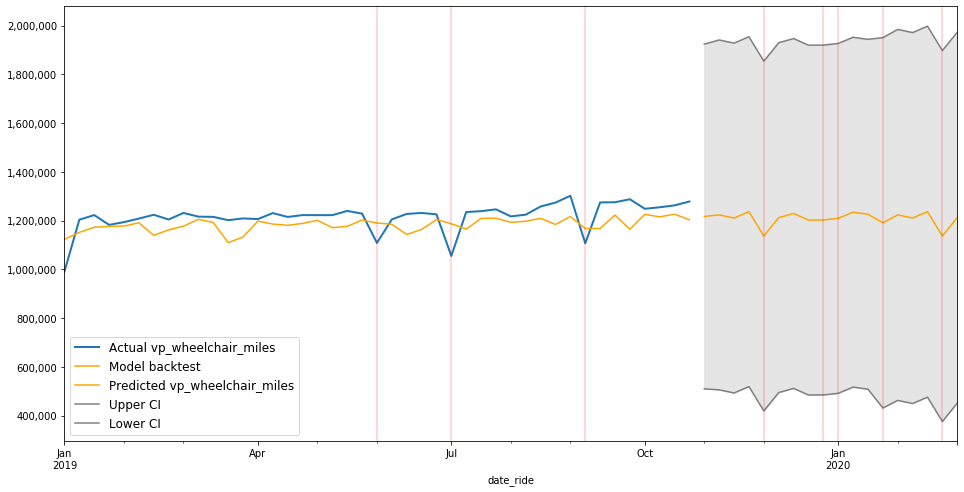

In [203]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [204]:
# make final series

vp_wheelchair_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_miles

vp_wheelchair_miles  lower_vp_wheelchair_miles  \
2019-11-03         1,216,901.96                 509,783.69   
2019-11-10         1,223,363.90                 505,808.53   
2019-11-17         1,210,455.89                 492,900.53   
2019-11-24         1,236,634.20                 519,078.83   
2019-12-01         1,136,652.25                 419,096.88   
2019-12-08         1,212,125.09                 494,569.72   
2019-12-15         1,229,264.18                 511,708.81   
2019-12-22         1,202,136.27                 484,580.90   
2019-12-29         1,202,405.46                 484,850.09   
2020-01-05         1,209,112.71                 491,557.34   
2020-01-12         1,234,581.23                 517,025.87   
2020-01-19         1,225,972.44                 508,417.08   
2020-01-26         1,190,975.23                 431,282.48   
2020-02-02         1,223,363.90                 462,453.80   
2020-02-09         1,210,455.89                 449,545.79   
2020-02-16         1,236,634.20                 475,724.10   
2020-02-23         1,136,652.25                 375,742.14   
2020-03-01         1,212,125.09                 451,214.99   

            upper_vp_wheelchair_miles  
2019-11-03               1,924,020.23  
2019-11-10               1,940,919.27  
2019-11-17               1,928,011.26  
2019-11-24               1,954,189.57  
2019-12-01               1,854,207.61  
2019-12-08               1,929,680.46  
2019-12-15               1,946,819.54  
2019-12-22               1,919,691.64  
2019-12-29               1,919,960.83  
2020-01-05               1,926,668.08  
2020-01-12               1,952,136.60  
2020-01-19               1,943,527.81  
2020-01-26               1,950,667.98  
2020-02-02               1,984,274.00  
2020-02-09               1,971,365.99  
2020-02-16               1,997,544.30  
2020-02-23               1,897,562.35  
2020-03-01               1,973,035.19

# CPM

In [205]:
series = 'cpm'

In [206]:
model = ts.build_model(train[series],
                       p=3,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=3,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                               cpm   No. Observations:                  304
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 6)   Log Likelihood                 272.307
Date:                           Fri, 31 Jan 2020   AIC                           -528.614
Time:                                   13:46:04   BIC                           -499.064
Sample:                               01-05-2014   HQIC                          -516.784
                                    - 10-27-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday        0.0390      0.015      2.541      0.011       0.009       0.069
ar.L1         -0.6211      0.020    -30.357      0.000      -0.661      -0.581
ar.L2         -0.4594      0.032    -14.542      0.000      -0.521      -0.397
ar.L3         -0.2448      0.029     -8.511      0.000      -0.301      -0.188
ar.S.L6       -0.7396      0.029    -25.936      0.000      -0.796      -0.684
ar.S.L12      -0.5252      0.031    -16.780      0.000      -0.587      -0.464
ar.S.L18      -0.2669      0.026    -10.380      0.000      -0.317      -0.216
sigma2         0.0092      0.000     30.088      0.000       0.009       0.010
===================================================================================
Ljung-Box (Q):                       52.44   Jarque-Bera (JB):             32904.63
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -4.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [207]:
ts.get_dw(model)

1.4464733035218797

In [208]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

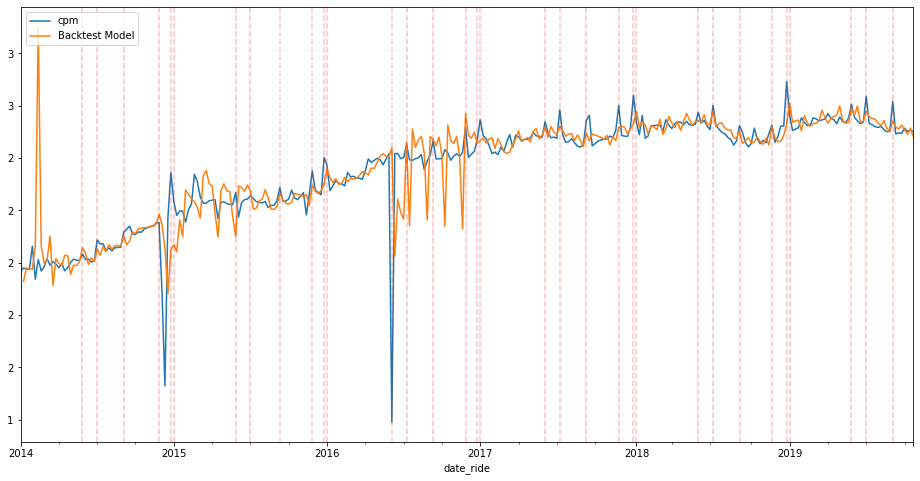

In [209]:
# plt the backtest

ts.plot_fit(train[series], backtest, train)

In [210]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [211]:
# conf intervals for oos

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [212]:
intervals.format("{:,.2f}")

In [213]:
# make df for plotting

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

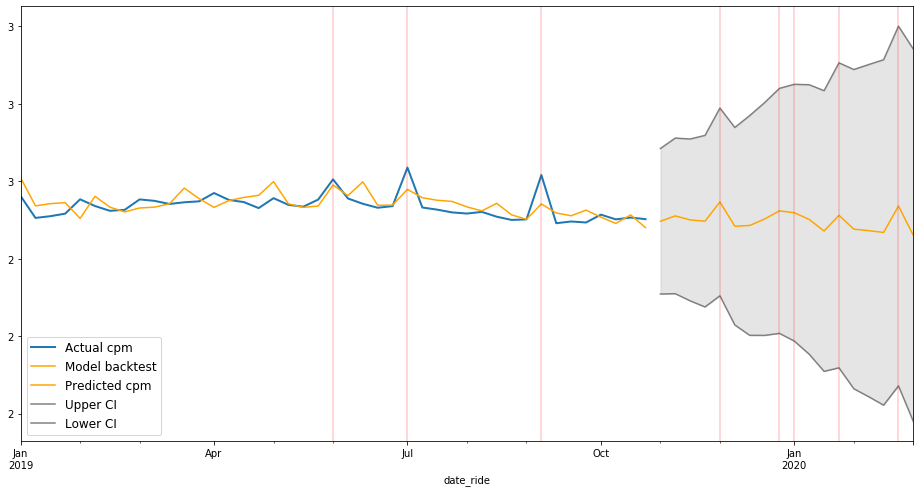

In [214]:
# plot oos 

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [215]:
# Make final series

cpm_fcast = ts.oos_weekly_df(model=model,
                       steps_ahead=horizon,
                       exog_data = oos_exog,
                       series = series,
                       add_date = False)

cpm_fcast

cpm  lower_cpm  upper_cpm
2019-11-03 2.50       2.31       2.68
2019-11-10 2.51       2.31       2.71
2019-11-17 2.50       2.29       2.71
2019-11-24 2.50       2.28       2.72
2019-12-01 2.55       2.30       2.79
2019-12-08 2.48       2.23       2.74
2019-12-15 2.49       2.20       2.77
2019-12-22 2.50       2.20       2.80
2019-12-29 2.52       2.21       2.84
2020-01-05 2.52       2.19       2.85
2020-01-12 2.50       2.15       2.85
2020-01-19 2.47       2.11       2.83
2020-01-26 2.51       2.12       2.91
2020-02-02 2.48       2.06       2.89
2020-02-09 2.47       2.04       2.90
2020-02-16 2.47       2.02       2.91
2020-02-23 2.54       2.07       3.00
2020-03-01 2.46       1.98       2.94

# Begin to Combine Data Frames

In [349]:
list_cols = list(wdf.columns)

# change holiday to holidays

list_cols[1] = 'holidays'

list_cols

['date_ride',
 'holidays',
 'gross_rides',
 'vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles',
 'riders',
 'cpm']

In [350]:
# remove riders and gross rides
exclude = ['date_ride', 'gross_rides', 'riders', 'holidays', 'cpm']
vp_cols = [e for e in list_cols if e not in exclude]

vp_cols


['vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles']

In [351]:
# make a list of dataframes using the columns
holidays = oos_exog

# create empty list
vp_df = []

for df in vp_cols:
    # use eval to handle the string name as actual df
    df = pd.DataFrame(eval(df))
    vp_df.append(df)
    

vp_df

[             vp_rides  lower_vp_rides  upper_vp_rides
 2019-11-03 654,561.24      594,656.24      714,466.24
 2019-11-10 634,320.10      573,526.23      695,113.96
 2019-11-17 638,680.01      577,177.68      700,182.34
 2019-11-24 640,499.44      578,430.87      702,568.02
 2019-12-01 520,933.29      458,411.16      583,455.42
 2019-12-08 655,924.58      581,468.92      730,380.24
 2019-12-15 634,343.52      558,943.93      709,743.11
 2019-12-22 640,381.50      564,228.14      716,534.86
 2019-12-29 508,344.54      431,587.85      585,101.23
 2020-01-05 522,401.18      445,160.69      599,641.68
 2020-01-12 657,092.39      568,682.74      745,502.03
 2020-01-19 633,528.20      544,158.14      722,898.26
 2020-01-26 507,016.73      416,878.51      597,154.95
 2020-02-02 642,172.25      551,418.43      732,926.08
 2020-02-09 656,639.84      565,391.89      747,887.80
 2020-02-16 657,211.26      554,375.94      760,046.57
 2020-02-23 500,798.81      396,962.30      604,635.31
 2020-03-0

In [352]:
# concat them all into a single df
combined_wide = pd.concat(vp_df, axis = 1)
combined_wide

vp_rides  lower_vp_rides  upper_vp_rides      vp_costs  \
2019-11-03 654,561.24      594,656.24      714,466.24 19,935,075.69   
2019-11-10 634,320.10      573,526.23      695,113.96 19,862,346.15   
2019-11-17 638,680.01      577,177.68      700,182.34 19,920,053.36   
2019-11-24 640,499.44      578,430.87      702,568.02 19,872,694.49   
2019-12-01 520,933.29      458,411.16      583,455.42 16,197,706.61   
2019-12-08 655,924.58      581,468.92      730,380.24 19,935,586.67   
2019-12-15 634,343.52      558,943.93      709,743.11 20,001,772.61   
2019-12-22 640,381.50      564,228.14      716,534.86 19,971,030.33   
2019-12-29 508,344.54      431,587.85      585,101.23 16,289,870.62   
2020-01-05 522,401.18      445,160.69      599,641.68 16,258,258.79   
2020-01-12 657,092.39      568,682.74      745,502.03 20,077,862.79   
2020-01-19 633,528.20      544,158.14      722,898.26 20,048,337.88   
2020-01-26 507,016.73      416,878.51      597,154.95 16,367,326.18   
2020-02-02 642,172.25      551,418.43      732,926.08 20,087,044.60   
2020-02-09 656,639.84      565,391.89      747,887.80 20,155,910.68   
2020-02-16 657,211.26      554,375.94      760,046.57 20,125,342.37   
2020-02-23 500,798.81      396,962.30      604,635.31 16,444,116.57   
2020-03-01 641,064.73      536,426.67      745,702.80 20,163,494.86   

            lower_vp_costs  upper_vp_costs     vp_miles  lower_vp_miles  \
2019-11-03   18,353,158.90   21,516,992.48 8,097,899.33    6,821,787.26   
2019-11-10   18,081,547.31   21,643,144.99 7,918,997.16    6,505,313.27   
2019-11-17   17,975,928.85   21,864,177.87 7,828,118.50    6,330,087.36   
2019-11-24   17,772,934.78   21,972,454.20 7,930,480.76    6,358,478.16   
2019-12-01   13,976,074.05   18,419,339.17 6,597,756.76    4,956,039.54   
2019-12-08   17,589,618.06   22,281,555.27 8,194,229.49    6,256,089.72   
2019-12-15   17,510,924.87   22,492,620.35 7,991,237.76    5,917,212.80   
2019-12-22   17,357,227.13   22,584,833.54 7,885,414.79    5,699,901.61   
2019-12-29   13,549,324.39   19,030,416.84 6,538,856.71    4,249,759.43   
2020-01-05   13,402,271.81   19,114,245.78 6,694,873.98    4,307,080.91   
2020-01-12   17,104,541.28   23,051,184.31 8,277,097.35    5,570,891.44   
2020-01-19   16,966,405.63   23,130,270.14 8,024,278.45    5,152,012.99   
2020-01-26   13,172,374.89   19,562,277.48 6,499,360.31    3,486,399.73   
2020-02-02   16,787,978.69   23,386,110.50 8,090,453.96    4,945,633.15   
2020-02-09   16,748,558.12   23,563,263.24 8,261,865.83    4,990,907.34   
2020-02-16   16,617,696.15   23,632,988.58 8,351,094.38    4,673,915.03   
2020-02-23   12,832,114.66   20,056,118.48 6,628,246.09    2,737,460.39   
2020-03-01   16,454,456.56   23,872,533.16 8,069,302.52    3,996,939.07   

            upper_vp_miles  vp_ambulatory_rides  lower_vp_ambulatory_rides  \
2019-11-03    9,374,011.41           777,282.82                 723,724.09   
2019-11-10    9,332,681.05           782,283.57                 706,478.07   
2019-11-17    9,326,149.64           794,254.37                 704,819.30   
2019-11-24    9,502,483.36           793,086.66                 689,060.27   
2019-12-01    8,239,473.98           688,949.07                 562,934.50   
2019-12-08   10,132,369.26           789,350.34                 642,886.07   
2019-12-15   10,065,262.72           800,106.53                 638,050.44   
2019-12-22   10,070,927.97           797,363.94                 619,289.76   
2019-12-29    8,827,953.99           694,513.35                 497,189.59   
2020-01-05    9,082,667.05           698,827.11                 482,881.49   
2020-01-12   10,983,303.25           804,796.64                 573,106.00   
2020-01-19   10,896,543.90           801,537.07                 554,012.77   
2020-01-26    9,512,320.89           698,821.18                 433,851.71   
2020-02-02   11,235,274.77           800,006.77                 518,020.20   
2020-02-09   11,532,824.32           808,765.34                 511

In [220]:
# SKIP THIS STEP
# truncate the series to remove past

# week_incr = 1

# begin = short_horizon + week_incr

# combined_wide_red = combined_wide.iloc[begin:]
# combined_wide_red.head()

In [345]:
# concatonate them all


all_forecasts = pd.concat([holidays, gross_rides_fcast, riders_fcast, cpm_fcast, combined_wide], axis = 1)
all_forecasts.head()


holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2019-11-03     0.00          nan                nan                nan   
2019-11-10     0.00          nan                nan                nan   
2019-11-17     0.00          nan                nan                nan   
2019-11-24     0.00          nan                nan                nan   
2019-12-01     1.00          nan                nan                nan   

           fcast_date  riders  lower_riders  upper_riders  cpm  lower_cpm  \
2019-11-03        NaN     nan           nan           nan 2.50       2.31   
2019-11-10        NaN     nan           nan           nan 2.51       2.31   
2019-11-17        NaN     nan           nan           nan 2.50       2.29   
2019-11-24        NaN     nan           nan           nan 2.50       2.28   
2019-12-01        NaN     nan           nan           nan 2.55       2.30   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-11-03       2.68 654,561.24      594,656.24      714,466.24   
2019-11-10       2.71 634,320.10      573,526.23      695,113.96   
2019-11-17       2.71 638,680.01      577,177.68      700,182.34   
2019-11-24       2.72 640,499.44      578,430.87      702,568.02   
2019-12-01       2.79 520,933.29      458,411.16      583,455.42   

                vp_costs  lower_vp_costs  upper_vp_costs     vp_miles  \
2019-11-03 19,935,075.69   18,353,158.90   21,516,992.48 8,097,899.33   
2019-11-10 19,862,346.15   18,081,547.31   21,643,144.99 7,918,997.16   
2019-11-17 19,920,053.36   17,975,928.85   21,864,177.87 7,828,118.50   
2019-11-24 19,872,694.49   17,772,934.78   21,972,454.20 7,930,480.76   
2019-12-01 16,197,706.61   13,976,074.05   18,419,339.17 6,597,756.76   

            lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
2019-11-03    6,821,787.26    9,374,011.41           777,282.82   
2019-11-10    6,505,313.27    9,332,681.05           782,283.57   
2019-11-17    6,330,087.36    9,326,149.64           794,254.37   
2019-11-24    6,358,478.16    9,502,483.36           793,086.66   
2019-12-01    4,956,039.54    8,239,473.98           688,949.07   

            lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
2019-11-03                 723,724.09                 830,841.54   
2019-11-10                 706,478.07                 858,089.07   
2019-11-17                 704,819.30                 883,689.43   
2019-11-24                 689,060.27                 897,113.06   
2019-12-01                 562,934.50                 814,963.65   

            vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2019-11-03        14,108,652.16              12,844,346.31   
2019-11-10        13,694,029.70              12,414,022.84   
2019-11-17        13,724,522.16              12,431,635.33   
2019-11-24        13,769,958.74              12,466,484.00   
2019-12-01        11,311,828.65               9,999,635.61   

            upper_vp_ambulatory_costs  vp_ambulatory_miles  \
2019-11-03              15,372,958.01         9,632,314.42   
2019-11-10              14,974,036.55         9,684,635.20   
2019-11-17              15,017,408.99         9,808,092.58   
2019-11-24              15,073,433.48         9,769,338.44   
2019-12-01              12,624,021.68         8,391,605.92   

            lower_vp_ambulatory_miles  upper_vp_ambulatory_miles  \
2019-11-03               8,741,932.23              10,522,696.61   
2019-11-10               8,485,956.29              10,883,314.11   
2019-11-17               8,427,042.03              11,189,143.14   
2019-11-24               8,170,043.44              11,368,633.44   
2019-12-01               6,515,554.40              10,267,657.44   

            vp_stretcher_rides  lower_vp_stretcher_rides  \
2019-11-03           15,724.26                 14,709.79   
2019-11-10           15,731.75                 14,330.39   
2019-11-17           15,793.32                 14,184.09   
2019-11-24           15,761.38                 13

In [353]:
all_forecasts.tail()

holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2020-02-09     0.00   872,979.80         736,671.32       1,009,288.29   
2020-02-16     0.00   913,126.37         763,268.46       1,062,984.27   
2020-02-23     1.00   887,673.48         726,046.10       1,049,300.87   
2020-03-01     0.00   746,429.75         574,265.61         918,593.89   
2020-03-08      nan   876,214.55         693,665.75       1,058,763.35   

            fcast_date     riders  lower_riders  upper_riders  cpm  lower_cpm  \
2020-02-09  2020-01-31 424,877.96    357,706.42    492,049.50 2.47       2.04   
2020-02-16  2020-01-31 442,303.96    368,647.12    515,960.80 2.47       2.02   
2020-02-23  2020-01-31 429,937.13    350,051.89    509,822.37 2.54       2.07   
2020-03-01  2020-01-31 363,024.78    277,609.19    448,440.37 2.46       1.98   
2020-03-08  2020-01-31 426,347.22    336,021.38    516,673.07  nan        nan   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2020-02-09       2.90 656,639.84      565,391.89      747,887.80   
2020-02-16       2.91 657,211.26      554,375.94      760,046.57   
2020-02-23       3.00 500,798.81      396,962.30      604,635.31   
2020-03-01       2.94 641,064.73      536,426.67      745,702.80   
2020-03-08        nan        nan             nan             nan   

                vp_costs  lower_vp_costs  upper_vp_costs     vp_miles  \
2020-02-09 20,155,910.68   16,748,558.12   23,563,263.24 8,261,865.83   
2020-02-16 20,125,342.37   16,617,696.15   23,632,988.58 8,351,094.38   
2020-02-23 16,444,116.57   12,832,114.66   20,056,118.48 6,628,246.09   
2020-03-01 20,163,494.86   16,454,456.56   23,872,533.16 8,069,302.52   
2020-03-08           nan             nan             nan          nan   

            lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
2020-02-09    4,990,907.34   11,532,824.32           808,765.34   
2020-02-16    4,673,915.03   12,028,273.74           805,509.34   
2020-02-23    2,737,460.39   10,519,031.80           702,700.50   
2020-03-01    3,996,939.07   12,141,665.96           804,261.89   
2020-03-08             nan             nan                  nan   

            lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
2020-02-09                 511,567.57               1,105,963.12   
2020-02-16                 493,178.09               1,117,840.59   
2020-02-23                 374,122.44               1,031,278.56   
2020-03-01                 459,806.79               1,148,716.99   
2020-03-08                        nan                        nan   

            vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2020-02-09        14,131,750.34              12,245,174.43   
2020-02-16        14,184,039.22              12,052,927.75   
2020-02-23        10,957,584.24               8,806,647.74   
2020-03-01        13,787,395.32              11,620,150.72   
2020-03-08                  nan                        nan   

            upper_vp_ambulatory_costs  vp_ambulatory_miles  \
2020-02-09              16,018,326.26         9,999,326.11   
2020-02-16              16,315,150.68         9,950,175.20   
2020-02-23              13,108,520.74         8,565,174.33   
2020-03-01              15,954,639.92         9,973,121.70   
2020-03-08                        nan                  nan   

            lower_vp_ambulatory_miles  upper_vp_ambulatory_miles  \
2020-02-09               6,145,893.46              13,852,758.77   
2020-02-16               5,931,733.98              13,968,616.43   
2020-02-23               4,369,757.97              12,760,590.69   
2020-03-01               5,608,805.02              14,337,438.37   
2020-03-08                        nan                        nan   

            vp_stretcher_rides  lower_vp_stretcher_rides  \
2020-02-09           15,655.41                 11,310.20   
2020-02-16           15,667.51                 11,135.99   
2020-02-23           14,034.61                  9,305.68   
2020-03-01           15,5

In [354]:
# drop the 2020-03-08 value

all_forecasts = all_forecasts.iloc[0:len(all_forecasts)-1]

# set the forecast date for the whole dataset
from datetime import datetime as dt

all_forecasts['fcast_date'] = dt.now().date()
all_forecasts

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2019-11-03     0.00          nan                nan                nan   
2019-11-10     0.00          nan                nan                nan   
2019-11-17     0.00          nan                nan                nan   
2019-11-24     0.00          nan                nan                nan   
2019-12-01     1.00          nan                nan                nan   
2019-12-08     0.00          nan                nan                nan   
2019-12-15     0.00          nan                nan                nan   
2019-12-22     0.00          nan                nan                nan   
2019-12-29     1.00          nan                nan                nan   
2020-01-05     1.00          nan                nan                nan   
2020-01-12     0.00   755,680.08         693,601.39         817,758.77   
2020-01-19     0.00   889,526.43         801,867.85         977,185.01   
2020-01-26     1.00   886,292.36         780,161.60         992,423.12   
2020-02-02     0.00   755,059.23         633,387.89         876,730.57   
2020-02-09     0.00   872,979.80         736,671.32       1,009,288.29   
2020-02-16     0.00   913,126.37         763,268.46       1,062,984.27   
2020-02-23     1.00   887,673.48         726,046.10       1,049,300.87   
2020-03-01     0.00   746,429.75         574,265.61         918,593.89   

            fcast_date     riders  lower_riders  upper_riders  cpm  lower_cpm  \
2019-11-03  2020-02-05        nan           nan           nan 2.50       2.31   
2019-11-10  2020-02-05        nan           nan           nan 2.51       2.31   
2019-11-17  2020-02-05        nan           nan           nan 2.50       2.29   
2019-11-24  2020-02-05        nan           nan           nan 2.50       2.28   
2019-12-01  2020-02-05        nan           nan           nan 2.55       2.30   
2019-12-08  2020-02-05        nan           nan           nan 2.48       2.23   
2019-12-15  2020-02-05        nan           nan           nan 2.49       2.20   
2019-12-22  2020-02-05        nan           nan           nan 2.50       2.20   
2019-12-29  2020-02-05        nan           nan           nan 2.52       2.21   
2020-01-05  2020-02-05        nan           nan           nan 2.52       2.19   
2020-01-12  2020-02-05 366,720.13    337,202.98    396,237.28 2.50       2.15   
2020-01-19  2020-02-05 430,661.06    388,160.28    473,161.84 2.47       2.11   
2020-01-26  2020-02-05 430,437.39    377,918.99    482,955.78 2.51       2.12   
2020-02-02  2020-02-05 368,198.35    307,782.91    428,613.79 2.48       2.06   
2020-02-09  2020-02-05 424,877.96    357,706.42    492,049.50 2.47       2.04   
2020-02-16  2020-02-05 442,303.96    368,647.12    515,960.80 2.47       2.02   
2020-02-23  2020-02-05 429,937.13    350,051.89    509,822.37 2.54       2.07   
2020-03-01  2020-02-05 363,024.78    277,609.19    448,440.37 2.46       1.98   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-11-03       2.68 654,561.24      594,656.24      714,466.24   
2019-11-10       2.71 634,320.10      573,526.23      695,113.96   
2019-11-17       2.71 638,680.01      577,177.68      700,182.34   
2019-11-24       2.72 640,499.44      578,430.87      702,568.02   
2019-12-01       2.79 520,933.29      458,411.16      583,455.42   
2019-12-08       2.74 655,924.58      581,468.92      730,380.24   
2019-12-15       2.77 634,343.52      558,943.93      709,743.11   
2019-12-22       2.80 640,381.50      564,228.14      716,534.86   
2019-12-29       2.84 508,344.54      431,587.85      585,101.23   
2020-01-05       2.85 522,401.18      445,160.69      599,641.68   
2020-01-12       2.85 657,092.39      568,682.74      745,502.03   
2020-01-19       2.83 633,528.20      544,158.14      722,898.26   
2020-01-26       2.91 507,016.73      416,878.51      597,154.95   
2020-02-02       2.89 642,172.25      551,418.43      732,926.08   
2020-02-09       2.90 656,639.84      565,391

In [360]:
# move the fcast_date for simplicity

fc = all_forecasts['fcast_date']
all_forecasts.drop(labels=['fcast_date'], axis=1,inplace = True)
all_forecasts.insert(0, 'fcast_date', fc)

all_forecasts.head()

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


fcast_date  holiday  gross_rides  lower_gross_rides  \
2019-11-03  2020-02-05     0.00          nan                nan   
2019-11-10  2020-02-05     0.00          nan                nan   
2019-11-17  2020-02-05     0.00          nan                nan   
2019-11-24  2020-02-05     0.00          nan                nan   
2019-12-01  2020-02-05     1.00          nan                nan   

            upper_gross_rides  riders  lower_riders  upper_riders  cpm  \
2019-11-03                nan     nan           nan           nan 2.50   
2019-11-10                nan     nan           nan           nan 2.51   
2019-11-17                nan     nan           nan           nan 2.50   
2019-11-24                nan     nan           nan           nan 2.50   
2019-12-01                nan     nan           nan           nan 2.55   

            lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-11-03       2.31       2.68 654,561.24      594,656.24      714,466.24   
2019-11-10       2.31       2.71 634,320.10      573,526.23      695,113.96   
2019-11-17       2.29       2.71 638,680.01      577,177.68      700,182.34   
2019-11-24       2.28       2.72 640,499.44      578,430.87      702,568.02   
2019-12-01       2.30       2.79 520,933.29      458,411.16      583,455.42   

                vp_costs  lower_vp_costs  upper_vp_costs     vp_miles  \
2019-11-03 19,935,075.69   18,353,158.90   21,516,992.48 8,097,899.33   
2019-11-10 19,862,346.15   18,081,547.31   21,643,144.99 7,918,997.16   
2019-11-17 19,920,053.36   17,975,928.85   21,864,177.87 7,828,118.50   
2019-11-24 19,872,694.49   17,772,934.78   21,972,454.20 7,930,480.76   
2019-12-01 16,197,706.61   13,976,074.05   18,419,339.17 6,597,756.76   

            lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
2019-11-03    6,821,787.26    9,374,011.41           777,282.82   
2019-11-10    6,505,313.27    9,332,681.05           782,283.57   
2019-11-17    6,330,087.36    9,326,149.64           794,254.37   
2019-11-24    6,358,478.16    9,502,483.36           793,086.66   
2019-12-01    4,956,039.54    8,239,473.98           688,949.07   

            lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
2019-11-03                 723,724.09                 830,841.54   
2019-11-10                 706,478.07                 858,089.07   
2019-11-17                 704,819.30                 883,689.43   
2019-11-24                 689,060.27                 897,113.06   
2019-12-01                 562,934.50                 814,963.65   

            vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2019-11-03        14,108,652.16              12,844,346.31   
2019-11-10        13,694,029.70              12,414,022.84   
2019-11-17        13,724,522.16              12,431,635.33   
2019-11-24        13,769,958.74              12,466,484.00   
2019-12-01        11,311,828.65               9,999,635.61   

            upper_vp_ambulatory_costs  vp_ambulatory_miles  \
2019-11-03              15,372,958.01         9,632,314.42   
2019-11-10              14,974,036.55         9,684,635.20   
2019-11-17              15,017,408.99         9,808,092.58   
2019-11-24              15,073,433.48         9,769,338.44   
2019-12-01              12,624,021.68         8,391,605.92   

            lower_vp_ambulatory_miles  upper_vp_ambulatory_miles  \
2019-11-03               8,741,932.23              10,522,696.61   
2019-11-10               8,485,956.29              10,883,314.11   
2019-11-17               8,427,042.03              11,189,143.14   
2019-11-24               8,170,043.44              11,368,633.44   
2019-12-01               6,515,554.40              10,267,657.44   

            vp_stretcher_rides  lower_vp_stretcher_rides  \
2019-11-03           15,724.26                 14,709.79   
2019-11-10           15,731.75                 14,330.39   
2019-11-17           15,793.32                 14,184.09   
2019-11-24           15,761.38             

In [367]:
# reset the index

# all_forecasts.reset_index(inplace=True)
# all_forecasts.rename(columns = {'date':'month_ending'}, inplace = True)

all_forecasts.rename(columns = {'index':'week_ending'}, inplace = True)

all_forecasts.set_index('week_ending', inplace = True)

all_forecasts.head()


fcast_date  holiday  gross_rides  lower_gross_rides  \
week_ending                                                        
2019-11-03   2020-02-05     0.00          nan                nan   
2019-11-10   2020-02-05     0.00          nan                nan   
2019-11-17   2020-02-05     0.00          nan                nan   
2019-11-24   2020-02-05     0.00          nan                nan   
2019-12-01   2020-02-05     1.00          nan                nan   

             upper_gross_rides  riders  lower_riders  upper_riders  cpm  \
week_ending                                                               
2019-11-03                 nan     nan           nan           nan 2.50   
2019-11-10                 nan     nan           nan           nan 2.51   
2019-11-17                 nan     nan           nan           nan 2.50   
2019-11-24                 nan     nan           nan           nan 2.50   
2019-12-01                 nan     nan           nan           nan 2.55   

             lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
week_ending                                                                    
2019-11-03        2.31       2.68 654,561.24      594,656.24      714,466.24   
2019-11-10        2.31       2.71 634,320.10      573,526.23      695,113.96   
2019-11-17        2.29       2.71 638,680.01      577,177.68      700,182.34   
2019-11-24        2.28       2.72 640,499.44      578,430.87      702,568.02   
2019-12-01        2.30       2.79 520,933.29      458,411.16      583,455.42   

                 vp_costs  lower_vp_costs  upper_vp_costs     vp_miles  \
week_ending                                                              
2019-11-03  19,935,075.69   18,353,158.90   21,516,992.48 8,097,899.33   
2019-11-10  19,862,346.15   18,081,547.31   21,643,144.99 7,918,997.16   
2019-11-17  19,920,053.36   17,975,928.85   21,864,177.87 7,828,118.50   
2019-11-24  19,872,694.49   17,772,934.78   21,972,454.20 7,930,480.76   
2019-12-01  16,197,706.61   13,976,074.05   18,419,339.17 6,597,756.76   

             lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
week_ending                                                        
2019-11-03     6,821,787.26    9,374,011.41           777,282.82   
2019-11-10     6,505,313.27    9,332,681.05           782,283.57   
2019-11-17     6,330,087.36    9,326,149.64           794,254.37   
2019-11-24     6,358,478.16    9,502,483.36           793,086.66   
2019-12-01     4,956,039.54    8,239,473.98           688,949.07   

             lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
week_ending                                                         
2019-11-03                  723,724.09                 830,841.54   
2019-11-10                  706,478.07                 858,089.07   
2019-11-17                  704,819.30                 883,689.43   
2019-11-24                  689,060.27                 897,113.06   
2019-12-01                  562,934.50                 814,963.65   

             vp_ambulatory_costs  lower_vp_ambulatory_costs  \
week_ending                                                   
2019-11-03         14,108,652.16              12,844,346.31   
2019-11-10         13,694,029.70              12,414,022.84   
2019-11-17         13,724,522.16              12,431,635.33   
2019-11-24         13,769,958.74              12,466,484.00   
2019-12-01         11,311,828.65               9,999,635.61   

             upper_vp_ambulatory_costs  vp_ambulatory_miles  \
week_ending                                                   
2019-11-03               15,372,958.01         9,632,314.42   
2019-11-10               14,974,036.55         9,684,635.20   
2019-11-17               15,017,408.99         9,808,092.58   
2019-11-24               15,073,433.48         9,769,338.44   
2019-12-01               12,624,021.68         8,391,605.92   

             lower_vp_ambulatory_miles  upper_vp_ambulatory_miles  \
week_ending     

In [369]:
all_cols = list(all_forecasts.columns)
all_cols

['fcast_date',
 'holiday',
 'gross_rides',
 'lower_gross_rides',
 'upper_gross_rides',
 'riders',
 'lower_riders',
 'upper_riders',
 'cpm',
 'lower_cpm',
 'upper_cpm',
 'vp_rides',
 'lower_vp_rides',
 'upper_vp_rides',
 'vp_costs',
 'lower_vp_costs',
 'upper_vp_costs',
 'vp_miles',
 'lower_vp_miles',
 'upper_vp_miles',
 'vp_ambulatory_rides',
 'lower_vp_ambulatory_rides',
 'upper_vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'lower_vp_ambulatory_costs',
 'upper_vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'lower_vp_ambulatory_miles',
 'upper_vp_ambulatory_miles',
 'vp_stretcher_rides',
 'lower_vp_stretcher_rides',
 'upper_vp_stretcher_rides',
 'vp_stretcher_costs',
 'lower_vp_stretcher_costs',
 'upper_vp_stretcher_costs',
 'vp_stretcher_miles',
 'lower_vp_stretcher_miles',
 'upper_vp_stretcher_miles',
 'vp_wheelchair_rides',
 'lower_vp_wheelchair_rides',
 'upper_vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'lower_vp_wheelchair_costs',
 'upper_vp_wheelchair_costs',
 'vp_wheelchair_

In [370]:
# change names of gross_rides, riders and cpm

col_dict = {'gross_rides': 'gross_rides_fcast', 'riders': 'riders_fcast', 'cpm': 'cpm_fcast'} 

all_forecasts.columns = [col_dict.get(x, x) for x in all_forecasts.columns]


all_forecasts.head(12)


fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-11-03   2020-02-05     0.00                nan                nan   
2019-11-10   2020-02-05     0.00                nan                nan   
2019-11-17   2020-02-05     0.00                nan                nan   
2019-11-24   2020-02-05     0.00                nan                nan   
2019-12-01   2020-02-05     1.00                nan                nan   
2019-12-08   2020-02-05     0.00                nan                nan   
2019-12-15   2020-02-05     0.00                nan                nan   
2019-12-22   2020-02-05     0.00                nan                nan   
2019-12-29   2020-02-05     1.00                nan                nan   
2020-01-05   2020-02-05     1.00                nan                nan   
2020-01-12   2020-02-05     0.00         755,680.08         693,601.39   
2020-01-19   2020-02-05     0.00         889,526.43         801,867.85   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-11-03                 nan           nan           nan           nan   
2019-11-10                 nan           nan           nan           nan   
2019-11-17                 nan           nan           nan           nan   
2019-11-24                 nan           nan           nan           nan   
2019-12-01                 nan           nan           nan           nan   
2019-12-08                 nan           nan           nan           nan   
2019-12-15                 nan           nan           nan           nan   
2019-12-22                 nan           nan           nan           nan   
2019-12-29                 nan           nan           nan           nan   
2020-01-05                 nan           nan           nan           nan   
2020-01-12          817,758.77    366,720.13    337,202.98    396,237.28   
2020-01-19          977,185.01    430,661.06    388,160.28    473,161.84   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-11-03        2.50       2.31       2.68 654,561.24      594,656.24   
2019-11-10        2.51       2.31       2.71 634,320.10      573,526.23   
2019-11-17        2.50       2.29       2.71 638,680.01      577,177.68   
2019-11-24        2.50       2.28       2.72 640,499.44      578,430.87   
2019-12-01        2.55       2.30       2.79 520,933.29      458,411.16   
2019-12-08        2.48       2.23       2.74 655,924.58      581,468.92   
2019-12-15        2.49       2.20       2.77 634,343.52      558,943.93   
2019-12-22        2.50       2.20       2.80 640,381.50      564,228.14   
2019-12-29        2.52       2.21       2.84 508,344.54      431,587.85   
2020-01-05        2.52       2.19       2.85 522,401.18      445,160.69   
2020-01-12        2.50       2.15       2.85 657,092.39      568,682.74   
2020-01-19        2.47       2.11       2.83 633,528.20      544,158.14   

             upper_vp_rides      vp_costs  lower_vp_costs  upper_vp_costs  \
week_ending                                                                 
2019-11-03       714,466.24 19,935,075.69   18,353,158.90   21,516,992.48   
2019-11-10       695,113.96 19,862,346.15   18,081,547.31   21,643,144.99   
2019-11-17       700,182.34 19,920,053.36   17,975,928.85   21,864,177.87   
2019-11-24       702,568.02 19,872,694.49   17,772,934.78   21,972,454.20   
2019-12-01       583,455.42 16,197,706.61   13,976,074.05   18,419,339.17   
2019-12-08       730,380.24 19,935,586.67   17,589,618.06   22,281,555.27   
2019-12-15       709,743.11 20,001,772.61   17,510,924.87   22,492,620.35   
2019-12-22       716,534.86 19,971,030.33   17,357,227.13   22,584,833.54   
2019-12-29       585,101.23 16,289,870.62   13,549,324.39   19,030,416.84   
2020-01-05   

In [371]:
# make a date string for the file name

dt_str = all_forecasts['fcast_date'][0].strftime("%m%d%Y")
dt_str

'02052020'

In [247]:
os.getcwd()

'/Users/bryanbutler/Documents/Python/Forecasting/EWS'

In [248]:
# write wide and long to .csv

all_forecasts.to_csv('wide_ews_fcast_' + dt_str + '.csv', index = False)


In [334]:
# change holiday column type

all_forecasts['holiday'] = all_forecasts['holiday'].astype(bool)

all_forecasts.holiday.dtype

dtype('bool')

In [ ]:
# SKIP THIS STEP
# trim off long horizon

# all_forecasts = all_forecasts.iloc[0:8]
# all_forecasts

# Upload the Forecasts

In [249]:
from sqlalchemy import create_engine

In [250]:
# enter user for dw_datascience

uid = getpass.getpass(stream=sys.stderr)

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel
  This is separate from the ipykernel package so we can avoid doing imports until


········


In [251]:
pwd = getpass.getpass()

········


In [252]:
# make the connection and upload the dataframe
conn_string = 'postgresql+psycopg2://' + uid + ':' + pwd + '@rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com:5439/dw_main'

In [253]:
conn = create_engine(conn_string)

In [262]:
# all_forecasts

all_forecasts.to_sql(name = 'ews_forecasts',
          con = conn,
          schema='dw_datascience',
          index=False,
          if_exists='append')

In [ ]:
del uid, pwd, conn_string

In [372]:
agg_cols = all_forecasts.columns
agg_cols

Index(['fcast_date', 'holiday', 'gross_rides_fcast', 'lower_gross_rides',
       'upper_gross_rides', 'riders_fcast', 'lower_riders', 'upper_riders',
       'cpm_fcast', 'lower_cpm', 'upper_cpm', 'vp_rides', 'lower_vp_rides',
       'upper_vp_rides', 'vp_costs', 'lower_vp_costs', 'upper_vp_costs',
       'vp_miles', 'lower_vp_miles', 'upper_vp_miles', 'vp_ambulatory_rides',
       'lower_vp_ambulatory_rides', 'upper_vp_ambulatory_rides',
       'vp_ambulatory_costs', 'lower_vp_ambulatory_costs',
       'upper_vp_ambulatory_costs', 'vp_ambulatory_miles',
       'lower_vp_ambulatory_miles', 'upper_vp_ambulatory_miles',
       'vp_stretcher_rides', 'lower_vp_stretcher_rides',
       'upper_vp_stretcher_rides', 'vp_stretcher_costs',
       'lower_vp_stretcher_costs', 'upper_vp_stretcher_costs',
       'vp_stretcher_miles', 'lower_vp_stretcher_miles',
       'upper_vp_stretcher_miles', 'vp_wheelchair_rides',
       'lower_vp_wheelchair_rides', 'upper_vp_wheelchair_rides',
       'vp_wheelch

In [373]:
all_forecasts.head(10)

fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-11-03   2020-02-05     0.00                nan                nan   
2019-11-10   2020-02-05     0.00                nan                nan   
2019-11-17   2020-02-05     0.00                nan                nan   
2019-11-24   2020-02-05     0.00                nan                nan   
2019-12-01   2020-02-05     1.00                nan                nan   
2019-12-08   2020-02-05     0.00                nan                nan   
2019-12-15   2020-02-05     0.00                nan                nan   
2019-12-22   2020-02-05     0.00                nan                nan   
2019-12-29   2020-02-05     1.00                nan                nan   
2020-01-05   2020-02-05     1.00                nan                nan   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-11-03                 nan           nan           nan           nan   
2019-11-10                 nan           nan           nan           nan   
2019-11-17                 nan           nan           nan           nan   
2019-11-24                 nan           nan           nan           nan   
2019-12-01                 nan           nan           nan           nan   
2019-12-08                 nan           nan           nan           nan   
2019-12-15                 nan           nan           nan           nan   
2019-12-22                 nan           nan           nan           nan   
2019-12-29                 nan           nan           nan           nan   
2020-01-05                 nan           nan           nan           nan   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-11-03        2.50       2.31       2.68 654,561.24      594,656.24   
2019-11-10        2.51       2.31       2.71 634,320.10      573,526.23   
2019-11-17        2.50       2.29       2.71 638,680.01      577,177.68   
2019-11-24        2.50       2.28       2.72 640,499.44      578,430.87   
2019-12-01        2.55       2.30       2.79 520,933.29      458,411.16   
2019-12-08        2.48       2.23       2.74 655,924.58      581,468.92   
2019-12-15        2.49       2.20       2.77 634,343.52      558,943.93   
2019-12-22        2.50       2.20       2.80 640,381.50      564,228.14   
2019-12-29        2.52       2.21       2.84 508,344.54      431,587.85   
2020-01-05        2.52       2.19       2.85 522,401.18      445,160.69   

             upper_vp_rides      vp_costs  lower_vp_costs  upper_vp_costs  \
week_ending                                                                 
2019-11-03       714,466.24 19,935,075.69   18,353,158.90   21,516,992.48   
2019-11-10       695,113.96 19,862,346.15   18,081,547.31   21,643,144.99   
2019-11-17       700,182.34 19,920,053.36   17,975,928.85   21,864,177.87   
2019-11-24       702,568.02 19,872,694.49   17,772,934.78   21,972,454.20   
2019-12-01       583,455.42 16,197,706.61   13,976,074.05   18,419,339.17   
2019-12-08       730,380.24 19,935,586.67   17,589,618.06   22,281,555.27   
2019-12-15       709,743.11 20,001,772.61   17,510,924.87   22,492,620.35   
2019-12-22       716,534.86 19,971,030.33   17,357,227.13   22,584,833.54   
2019-12-29       585,101.23 16,289,870.62   13,549,324.39   19,030,416.84   
2020-01-05       599,641.68 16,258,258.79   13,402,271.81   19,114,245.78   

                vp_miles  lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
week_ending                                                                     
2019-11-03  8,097,899.33    6,821,787.26    9,374,011.41           777,282.82   
2019-11-10  7,918,997.16    6,505,313.27    9,332,681.05           782,283.57   
2019-11-17  7,828,118.50    6,330,087.36    9,326,149.64     

In [374]:
# convert holiday to 1, 0
all_forecasts['holiday'] =  all_forecasts['holiday'].astype(int)

all_forecasts.head()

fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-11-03   2020-02-05        0                nan                nan   
2019-11-10   2020-02-05        0                nan                nan   
2019-11-17   2020-02-05        0                nan                nan   
2019-11-24   2020-02-05        0                nan                nan   
2019-12-01   2020-02-05        1                nan                nan   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-11-03                 nan           nan           nan           nan   
2019-11-10                 nan           nan           nan           nan   
2019-11-17                 nan           nan           nan           nan   
2019-11-24                 nan           nan           nan           nan   
2019-12-01                 nan           nan           nan           nan   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-11-03        2.50       2.31       2.68 654,561.24      594,656.24   
2019-11-10        2.51       2.31       2.71 634,320.10      573,526.23   
2019-11-17        2.50       2.29       2.71 638,680.01      577,177.68   
2019-11-24        2.50       2.28       2.72 640,499.44      578,430.87   
2019-12-01        2.55       2.30       2.79 520,933.29      458,411.16   

             upper_vp_rides      vp_costs  lower_vp_costs  upper_vp_costs  \
week_ending                                                                 
2019-11-03       714,466.24 19,935,075.69   18,353,158.90   21,516,992.48   
2019-11-10       695,113.96 19,862,346.15   18,081,547.31   21,643,144.99   
2019-11-17       700,182.34 19,920,053.36   17,975,928.85   21,864,177.87   
2019-11-24       702,568.02 19,872,694.49   17,772,934.78   21,972,454.20   
2019-12-01       583,455.42 16,197,706.61   13,976,074.05   18,419,339.17   

                vp_miles  lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
week_ending                                                                     
2019-11-03  8,097,899.33    6,821,787.26    9,374,011.41           777,282.82   
2019-11-10  7,918,997.16    6,505,313.27    9,332,681.05           782,283.57   
2019-11-17  7,828,118.50    6,330,087.36    9,326,149.64           794,254.37   
2019-11-24  7,930,480.76    6,358,478.16    9,502,483.36           793,086.66   
2019-12-01  6,597,756.76    4,956,039.54    8,239,473.98           688,949.07   

             lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
week_ending                                                         
2019-11-03                  723,724.09                 830,841.54   
2019-11-10                  706,478.07                 858,089.07   
2019-11-17                  704,819.30                 883,689.43   
2019-11-24                  689,060.27                 897,113.06   
2019-12-01                  562,934.50                 814,963.65   

             vp_ambulatory_costs  lower_vp_ambulatory_costs  \
week_ending                                                   
2019-11-03         14,108,652.16              12,844,346.31   
2019-11-10         13,694,029.70              12,414,022.84   
2019-11-17         13,724,522.16              12,431,635.33   
2019-11-24         13,769,958.74              12,466,484.00   
2019-12-01         11,311,828.65               9,999,635.61   

             upper_vp_ambulatory_costs  vp_ambulatory_miles  \
week_ending                                                   
2019-11-03               15,372,958.01         9,632,314.42   
2019-11-10               14,974,036.55         9,684,635.20   
2019-11-17               15,017,408.99         9,808,092.58   
2019-11-24               15,073,433.48         9,769,338.44   
2019-12-01             

In [375]:
month_roll = all_forecasts.copy()
month_roll.head()

fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-11-03   2020-02-05        0                nan                nan   
2019-11-10   2020-02-05        0                nan                nan   
2019-11-17   2020-02-05        0                nan                nan   
2019-11-24   2020-02-05        0                nan                nan   
2019-12-01   2020-02-05        1                nan                nan   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-11-03                 nan           nan           nan           nan   
2019-11-10                 nan           nan           nan           nan   
2019-11-17                 nan           nan           nan           nan   
2019-11-24                 nan           nan           nan           nan   
2019-12-01                 nan           nan           nan           nan   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-11-03        2.50       2.31       2.68 654,561.24      594,656.24   
2019-11-10        2.51       2.31       2.71 634,320.10      573,526.23   
2019-11-17        2.50       2.29       2.71 638,680.01      577,177.68   
2019-11-24        2.50       2.28       2.72 640,499.44      578,430.87   
2019-12-01        2.55       2.30       2.79 520,933.29      458,411.16   

             upper_vp_rides      vp_costs  lower_vp_costs  upper_vp_costs  \
week_ending                                                                 
2019-11-03       714,466.24 19,935,075.69   18,353,158.90   21,516,992.48   
2019-11-10       695,113.96 19,862,346.15   18,081,547.31   21,643,144.99   
2019-11-17       700,182.34 19,920,053.36   17,975,928.85   21,864,177.87   
2019-11-24       702,568.02 19,872,694.49   17,772,934.78   21,972,454.20   
2019-12-01       583,455.42 16,197,706.61   13,976,074.05   18,419,339.17   

                vp_miles  lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
week_ending                                                                     
2019-11-03  8,097,899.33    6,821,787.26    9,374,011.41           777,282.82   
2019-11-10  7,918,997.16    6,505,313.27    9,332,681.05           782,283.57   
2019-11-17  7,828,118.50    6,330,087.36    9,326,149.64           794,254.37   
2019-11-24  7,930,480.76    6,358,478.16    9,502,483.36           793,086.66   
2019-12-01  6,597,756.76    4,956,039.54    8,239,473.98           688,949.07   

             lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
week_ending                                                         
2019-11-03                  723,724.09                 830,841.54   
2019-11-10                  706,478.07                 858,089.07   
2019-11-17                  704,819.30                 883,689.43   
2019-11-24                  689,060.27                 897,113.06   
2019-12-01                  562,934.50                 814,963.65   

             vp_ambulatory_costs  lower_vp_ambulatory_costs  \
week_ending                                                   
2019-11-03         14,108,652.16              12,844,346.31   
2019-11-10         13,694,029.70              12,414,022.84   
2019-11-17         13,724,522.16              12,431,635.33   
2019-11-24         13,769,958.74              12,466,484.00   
2019-12-01         11,311,828.65               9,999,635.61   

             upper_vp_ambulatory_costs  vp_ambulatory_miles  \
week_ending                                                   
2019-11-03               15,372,958.01         9,632,314.42   
2019-11-10               14,974,036.55         9,684,635.20   
2019-11-17               15,017,408.99         9,808,092.58   
2019-11-24               15,073,433.48         9,769,338.44   
2019-12-01             

In [378]:
list_cols =list(month_roll.columns)
list_cols

['fcast_date',
 'holiday',
 'gross_rides_fcast',
 'lower_gross_rides',
 'upper_gross_rides',
 'riders_fcast',
 'lower_riders',
 'upper_riders',
 'cpm_fcast',
 'lower_cpm',
 'upper_cpm',
 'vp_rides',
 'lower_vp_rides',
 'upper_vp_rides',
 'vp_costs',
 'lower_vp_costs',
 'upper_vp_costs',
 'vp_miles',
 'lower_vp_miles',
 'upper_vp_miles',
 'vp_ambulatory_rides',
 'lower_vp_ambulatory_rides',
 'upper_vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'lower_vp_ambulatory_costs',
 'upper_vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'lower_vp_ambulatory_miles',
 'upper_vp_ambulatory_miles',
 'vp_stretcher_rides',
 'lower_vp_stretcher_rides',
 'upper_vp_stretcher_rides',
 'vp_stretcher_costs',
 'lower_vp_stretcher_costs',
 'upper_vp_stretcher_costs',
 'vp_stretcher_miles',
 'lower_vp_stretcher_miles',
 'upper_vp_stretcher_miles',
 'vp_wheelchair_rides',
 'lower_vp_wheelchair_rides',
 'upper_vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'lower_vp_wheelchair_costs',
 'upper_vp_wheelchair_costs'

In [382]:
list_cols[46]

'upper_vp_wheelchair_miles'

In [383]:
month_df = month_roll.resample('M').agg({list_cols[1]: np.sum, list_cols[2]: np.sum, list_cols[3]: np.sum,
                                         list_cols[4]: np.sum, list_cols[5]: np.sum, list_cols[6]: np.sum,
                                         list_cols[7]: np.sum,
                                         list_cols[8]: np.mean, list_cols[9]: np.mean, list_cols[10]: np.mean,
                                         list_cols[11]: np.sum, list_cols[12]: np.sum, list_cols[13]: np.sum,
                                         list_cols[14]: np.sum, list_cols[15]: np.sum, list_cols[16]: np.sum,
                                         list_cols[17]: np.sum, list_cols[18]: np.sum, list_cols[19]: np.sum,
                                         list_cols[20]: np.sum, list_cols[21]: np.sum, list_cols[22]: np.sum,
                                         list_cols[23]: np.sum, list_cols[24]: np.sum, list_cols[25]: np.sum,
                                         list_cols[26]: np.sum, list_cols[27]: np.sum, list_cols[28]: np.sum,
                                         list_cols[29]: np.sum, list_cols[30]: np.sum, list_cols[31]: np.sum,
                                         list_cols[32]: np.sum, list_cols[33]: np.sum, list_cols[34]: np.sum,
                                         list_cols[35]: np.sum, list_cols[36]: np.sum, list_cols[37]: np.sum,
                                         list_cols[38]: np.sum, list_cols[39]: np.sum, list_cols[40]: np.sum,
                                         list_cols[41]: np.sum, list_cols[42]: np.sum, list_cols[43]: np.sum,
                                         list_cols[44]: np.sum, list_cols[45]: np.sum, list_cols[46]: np.sum,
                                        })




month_df

holiday  gross_rides_fcast  lower_gross_rides  upper_gross_rides  \
week_ending                                                                     
2019-11-30         0               0.00               0.00               0.00   
2019-12-31         2               0.00               0.00               0.00   
2020-01-31         2       2,531,498.87       2,275,630.84       2,787,366.90   
2020-02-29         1       3,428,838.89       2,859,373.77       3,998,304.00   
2020-03-31         0         746,429.75         574,265.61         918,593.89   

             riders_fcast  lower_riders  upper_riders  cpm_fcast  lower_cpm  \
week_ending                                                                   
2019-11-30           0.00          0.00          0.00       2.50       2.30   
2019-12-31           0.00          0.00          0.00       2.51       2.23   
2020-01-31   1,227,818.58  1,103,282.26  1,352,354.90       2.50       2.14   
2020-02-29   1,665,317.40  1,384,188.35  1,946,446.46       2.49       2.05   
2020-03-31     363,024.78    277,609.19    448,440.37       2.46       1.98   

             upper_cpm     vp_rides  lower_vp_rides  upper_vp_rides  \
week_ending                                                           
2019-11-30        2.71 2,568,060.79    2,323,791.02    2,812,330.56   
2019-12-31        2.79 2,959,927.42    2,594,640.00    3,325,214.84   
2020-01-31        2.86 2,320,038.50    1,974,880.08    2,665,196.92   
2020-02-29        2.93 2,456,822.16    2,068,148.56    2,845,495.76   
2020-03-31        2.94   641,064.73      536,426.67      745,702.80   

                 vp_costs  lower_vp_costs  upper_vp_costs      vp_miles  \
week_ending                                                               
2019-11-30  79,590,169.69   72,183,569.84   86,996,769.54 31,775,495.76   
2019-12-31  92,395,966.84   79,983,168.51  104,808,765.17 37,207,495.50   
2020-01-31  72,751,785.65   60,645,593.61   84,857,977.70 29,495,610.08   
2020-02-29  76,812,414.21   62,986,347.62   90,638,480.80 31,331,660.27   
2020-03-31  20,163,494.86   16,454,456.56   23,872,533.16  8,069,302.52   

             lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
week_ending                                                        
2019-11-30    26,015,666.05   37,535,325.46         3,146,907.41   
2019-12-31    27,079,003.09   47,335,987.90         3,770,283.22   
2020-01-31    18,516,385.08   40,474,835.09         3,003,982.00   
2020-02-29    17,347,915.91   45,315,404.63         3,116,981.96   
2020-03-31     3,996,939.07   12,141,665.96           804,261.89   

             lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
week_ending                                                         
2019-11-30                2,824,081.73               3,469,733.09   
2019-12-31                2,960,350.36               4,580,216.08   
2020-01-31                2,043,851.97               3,964,112.02   
2020-02-29                1,896,888.29               4,337,075.62   
2020-03-31                  459,806.79               1,148,716.99   

             vp_ambulatory_costs  lower_vp_ambulatory_costs  \
week_ending                                                   
2019-11-30         55,297,162.75              50,156,488.47   
2019-12-31         63,980,749.88              56,357,334.23   
2020-01-31         50,243,572.39              43,092,185.90   
2020-02-29         53,095,906.38              45,050,960.96   
2020-03-31         13,787,395.32              11,620,150.72   

             upper_vp_ambulatory_costs  vp_ambulatory_miles  \
week_ending                                                   
2019-11-30               60,437,837.04        38,894,380.64   
2019-12-31               71,604,165.52        46,331,331.64   
2020-01-31               57,394,958.88        36,880,570.85   
2020-02-29               61,140,851.81        38,428,145.42   
2020-03-31               15,954,639.92         9,973,121.70   

             lower_vp_